In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:

import torch
import torch.nn as nn

class SpatioTemporalLSTMCell(nn.Module):
    def __init__(self, in_channel, num_hidden, width, filter_size, stride, layer_norm):
        super(SpatioTemporalLSTMCell, self).__init__()

        self.num_hidden = num_hidden
        self.padding = filter_size // 2
        self._forget_bias = 1.0
        if layer_norm:
            self.conv_x = nn.Sequential(
                nn.Conv2d(in_channel, num_hidden * 7, kernel_size=filter_size, stride=stride, padding=self.padding, bias=False),
                nn.LayerNorm([num_hidden * 7, width, width])
            )
            self.conv_h = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 4, kernel_size=filter_size, stride=stride, padding=self.padding, bias=False),
                nn.LayerNorm([num_hidden * 4, width, width])
            )
            self.conv_m = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 3, kernel_size=filter_size, stride=stride, padding=self.padding, bias=False),
                nn.LayerNorm([num_hidden * 3, width, width])
            )
            self.conv_o = nn.Sequential(
                nn.Conv2d(num_hidden * 2, num_hidden, kernel_size=filter_size, stride=stride, padding=self.padding, bias=False),
                nn.LayerNorm([num_hidden, width, width])
            )
        else:
            self.conv_x = nn.Sequential(
                nn.Conv2d(in_channel, num_hidden * 7, kernel_size=filter_size, stride=stride, padding=self.padding, bias=False),
            )
            self.conv_h = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 4, kernel_size=filter_size, stride=stride, padding=self.padding, bias=False),
            )
            self.conv_m = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 3, kernel_size=filter_size, stride=stride, padding=self.padding, bias=False),
            )
            self.conv_o = nn.Sequential(
                nn.Conv2d(num_hidden * 2, num_hidden, kernel_size=filter_size, stride=stride, padding=self.padding, bias=False),
            )
        self.conv_last = nn.Conv2d(num_hidden * 2, num_hidden, kernel_size=1, stride=1, padding=0, bias=False)


    def forward(self, x_t, h_t, c_t, m_t):
        x_concat = self.conv_x(x_t)
        h_concat = self.conv_h(h_t)
        m_concat = self.conv_m(m_t)
        i_x, f_x, g_x, i_x_prime, f_x_prime, g_x_prime, o_x = torch.split(x_concat, self.num_hidden, dim=1)
        i_h, f_h, g_h, o_h = torch.split(h_concat, self.num_hidden, dim=1)
        i_m, f_m, g_m = torch.split(m_concat, self.num_hidden, dim=1)

        i_t = torch.sigmoid(i_x + i_h)
        f_t = torch.sigmoid(f_x + f_h + self._forget_bias)
        g_t = torch.tanh(g_x + g_h)

        delta_c = i_t * g_t
        c_new = f_t * c_t + delta_c

        i_t_prime = torch.sigmoid(i_x_prime + i_m)
        f_t_prime = torch.sigmoid(f_x_prime + f_m + self._forget_bias)
        g_t_prime = torch.tanh(g_x_prime + g_m)

        delta_m = i_t_prime * g_t_prime
        m_new = f_t_prime * m_t + delta_m

        mem = torch.cat((c_new, m_new), 1)
        o_t = torch.sigmoid(o_x + o_h + self.conv_o(mem))
        h_new = o_t * torch.tanh(self.conv_last(mem))

        return h_new, c_new, m_new, delta_c, delta_m

In [3]:
import torch
import torch.nn as nn

import torch.nn.functional as F




class PredRNN(nn.Module):
    def __init__(self, num_layers, num_hidden, configs):
            super(PredRNN, self).__init__()
    
            self.configs = configs
            self.visual = self.configs.visual
            self.visual_path = self.configs.visual_path
    
            self.frame_channel = configs.patch_size * configs.patch_size * configs.img_channel
            self.num_layers = num_layers
            self.num_hidden = num_hidden
            cell_list = []
    
            width = configs.img_width // configs.patch_size
            self.MSE_criterion = nn.MSELoss()
    
            for i in range(num_layers):
                in_channel = self.frame_channel if i == 0 else num_hidden[i - 1]
                cell_list.append(
                    SpatioTemporalLSTMCell(in_channel, num_hidden[i], width, configs.filter_size,
                                           configs.stride, configs.layer_norm)
                )
            self.cell_list = nn.ModuleList(cell_list)
            self.conv_last = nn.Conv2d(num_hidden[num_layers - 1], self.frame_channel, kernel_size=1, stride=1, padding=0,
                                       bias=False)
            # shared adapter
            adapter_num_hidden = num_hidden[0]
            self.adapter = nn.Conv2d(adapter_num_hidden, adapter_num_hidden, 1, stride=1, padding=0, bias=False)
    
    def forward(self, frames_tensor, mask_true):
        # [batch, length, height, width, channel] -> [batch, length, channel, height, width]
        frames = frames_tensor

        batch = frames.shape[0]
        height = frames.shape[3]
        width = frames.shape[4]

        next_frames = []
        h_t = []
        c_t = []
        delta_c_list = []
        delta_m_list = []
        if self.visual:
            delta_c_visual = []
            delta_m_visual = []

        decouple_loss = []

        for i in range(self.num_layers):
            zeros = torch.zeros([batch, self.num_hidden[i], height, width]).to(self.configs.device)
            h_t.append(zeros)
            c_t.append(zeros)
            delta_c_list.append(zeros)
            delta_m_list.append(zeros)

        memory = torch.zeros([batch, self.num_hidden[0], height, width]).to(self.configs.device)

        for t in range(self.configs.total_length - 1):

            if self.configs.reverse_scheduled_sampling == 1:
                # reverse schedule sampling
                if t == 0:
                    net = frames[:, t]
                else:
                    net = mask_true[:, t - 1] * frames[:, t] + (1 - mask_true[:, t - 1]) * x_gen
            else:
                # schedule sampling
                if t < self.configs.input_length:
                    net = frames[:, t]
                else:
                    net = mask_true[:, t - self.configs.input_length] * frames[:, t] + \
                          (1 - mask_true[:, t - self.configs.input_length]) * x_gen

            h_t[0], c_t[0], memory, delta_c, delta_m = self.cell_list[0](net, h_t[0], c_t[0], memory)
            delta_c_list[0] = F.normalize(self.adapter(delta_c).view(delta_c.shape[0], delta_c.shape[1], -1), dim=2)
            delta_m_list[0] = F.normalize(self.adapter(delta_m).view(delta_m.shape[0], delta_m.shape[1], -1), dim=2)
            if self.visual:
                delta_c_visual.append(delta_c.view(delta_c.shape[0], delta_c.shape[1], -1))
                delta_m_visual.append(delta_m.view(delta_m.shape[0], delta_m.shape[1], -1))

            for i in range(1, self.num_layers):
                h_t[i], c_t[i], memory, delta_c, delta_m = self.cell_list[i](h_t[i - 1], h_t[i], c_t[i], memory)
                delta_c_list[i] = F.normalize(self.adapter(delta_c).view(delta_c.shape[0], delta_c.shape[1], -1), dim=2)
                delta_m_list[i] = F.normalize(self.adapter(delta_m).view(delta_m.shape[0], delta_m.shape[1], -1), dim=2)
                if self.visual:
                    delta_c_visual.append(delta_c.view(delta_c.shape[0], delta_c.shape[1], -1))
                    delta_m_visual.append(delta_m.view(delta_m.shape[0], delta_m.shape[1], -1))

            x_gen = torch.tanh(self.conv_last(h_t[self.num_layers - 1]))
            next_frames.append(x_gen)
            # decoupling loss
            for i in range(0, self.num_layers):
                decouple_loss.append(
                    torch.mean(torch.abs(torch.cosine_similarity(delta_c_list[i], delta_m_list[i], dim=2))))

        if self.visual:
            # visualization of delta_c and delta_m
            delta_c_visual = torch.stack(delta_c_visual, dim=0)
            delta_m_visual = torch.stack(delta_m_visual, dim=0)
            visualization(self.configs.total_length, self.num_layers, delta_c_visual, delta_m_visual, self.visual_path)
            self.visual = 0

        decouple_loss = torch.mean(torch.stack(decouple_loss, dim=0))
        # [length, batch, channel, height, width] -> [batch, length, height, width, channel]
        next_frames = torch.stack(next_frames, dim=0).permute(1, 0, 2, 3, 4).contiguous()
        loss = self.MSE_criterion(next_frames, frames_tensor[:, 1:]) + self.configs.decouple_beta * decouple_loss
        return next_frames, loss

In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PrecipitationDataset(Dataset):
    def __init__(self, img_dir, sequence_length=4, transform=None):
        """
        Args:
            img_dir (str): Path to the directory with images.
            sequence_length (int): Number of consecutive images in a sequence.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = img_dir
        self.img_names = sorted(os.listdir(img_dir))[512:]  # Limit to the first 96 images
        self.sequence_length = sequence_length
        self.transform = transform

    def __len__(self):
        # Ensure we don't go out of bounds for sequences
        return len(self.img_names) - self.sequence_length
        

    def __getitem__(self, idx):
        
        sequence = []
    
        for i in range(self.sequence_length):
            img_path = os.path.join(self.img_dir, self.img_names[idx + i])
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            sequence.append(img)
    
        sequence = torch.stack(sequence)  # Shape: (T, C, H, W)
        
        return sequence

def get_data_loaders(img_dir, batch_size, num_workers=4, sequence_length=10):
    # Define any transformations (e.g., resize, normalize)
    transform = transforms.Compose([
        transforms.Resize((64,64)),  # Resize to match input size
        transforms.ToTensor(),        # Convert to PyTorch tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize to [-1, 1]
    ])
    
    # Create dataset instance
    dataset = PrecipitationDataset(img_dir, sequence_length=sequence_length, transform=transform)
    
    # Create DataLoader instance
    print(batch_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return data_loader

In [5]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

print("Memory freed!")
print(torch.cuda.memory_reserved() / 1024**3, "GB reserved")
print(torch.cuda.memory_allocated() / 1024**3, "GB allocated")
print(torch.cuda.max_memory_allocated() / 1024**3, "GB max allocated")

Memory freed!
0.0 GB reserved
0.0 GB allocated
0.0 GB max allocated


16


Epoch [1/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:   3%|▎         | 1/37 [00:03<02:06,  3.52s/batch, loss=0.979]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:   5%|▌         | 2/37 [00:04<01:06,  1.91s/batch, loss=0.743]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:   8%|▊         | 3/37 [00:05<00:47,  1.38s/batch, loss=0.518]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  11%|█         | 4/37 [00:05<00:37,  1.13s/batch, loss=0.417]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  14%|█▎        | 5/37 [00:06<00:32,  1.02s/batch, loss=0.35] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  16%|█▌        | 6/37 [00:07<00:28,  1.07batch/s, loss=0.29]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  19%|█▉        | 7/37 [00:08<00:26,  1.14batch/s, loss=0.247]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  22%|██▏       | 8/37 [00:08<00:24,  1.19batch/s, loss=0.218]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  24%|██▍       | 9/37 [00:09<00:23,  1.17batch/s, loss=0.193]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  27%|██▋       | 10/37 [00:10<00:22,  1.21batch/s, loss=0.176]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  30%|██▉       | 11/37 [00:11<00:20,  1.25batch/s, loss=0.164]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  32%|███▏      | 12/37 [00:12<00:19,  1.27batch/s, loss=0.152]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  35%|███▌      | 13/37 [00:12<00:19,  1.20batch/s, loss=0.141]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  38%|███▊      | 14/37 [00:13<00:18,  1.24batch/s, loss=0.136]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  41%|████      | 15/37 [00:14<00:17,  1.26batch/s, loss=0.133]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  43%|████▎     | 16/37 [00:15<00:16,  1.26batch/s, loss=0.131]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  46%|████▌     | 17/37 [00:16<00:18,  1.07batch/s, loss=0.136]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  49%|████▊     | 18/37 [00:17<00:16,  1.12batch/s, loss=0.133]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  51%|█████▏    | 19/37 [00:18<00:15,  1.18batch/s, loss=0.128]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  54%|█████▍    | 20/37 [00:18<00:13,  1.22batch/s, loss=0.118]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  57%|█████▋    | 21/37 [00:20<00:14,  1.09batch/s, loss=0.12] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  59%|█████▉    | 22/37 [00:20<00:13,  1.15batch/s, loss=0.113]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  62%|██████▏   | 23/37 [00:21<00:11,  1.19batch/s, loss=0.121]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  65%|██████▍   | 24/37 [00:22<00:10,  1.23batch/s, loss=0.122]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  68%|██████▊   | 25/37 [00:23<00:10,  1.16batch/s, loss=0.115]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  70%|███████   | 26/37 [00:24<00:09,  1.20batch/s, loss=0.108]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  73%|███████▎  | 27/37 [00:24<00:08,  1.24batch/s, loss=0.0994]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  76%|███████▌  | 28/37 [00:25<00:07,  1.27batch/s, loss=0.0967]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  78%|███████▊  | 29/37 [00:26<00:06,  1.19batch/s, loss=0.0999]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  81%|████████  | 30/37 [00:27<00:05,  1.17batch/s, loss=0.105] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  84%|████████▍ | 31/37 [00:28<00:04,  1.21batch/s, loss=0.106]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  86%|████████▋ | 32/37 [00:28<00:04,  1.24batch/s, loss=0.1]  

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  89%|████████▉ | 33/37 [00:29<00:03,  1.19batch/s, loss=0.0954]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.23batch/s, loss=0.0899]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.26batch/s, loss=0.0885]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]:  97%|█████████▋| 36/37 [00:32<00:00,  1.29batch/s, loss=0.0887]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [1/10]: 100%|██████████| 37/37 [00:33<00:00,  1.12batch/s, loss=0.0873]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


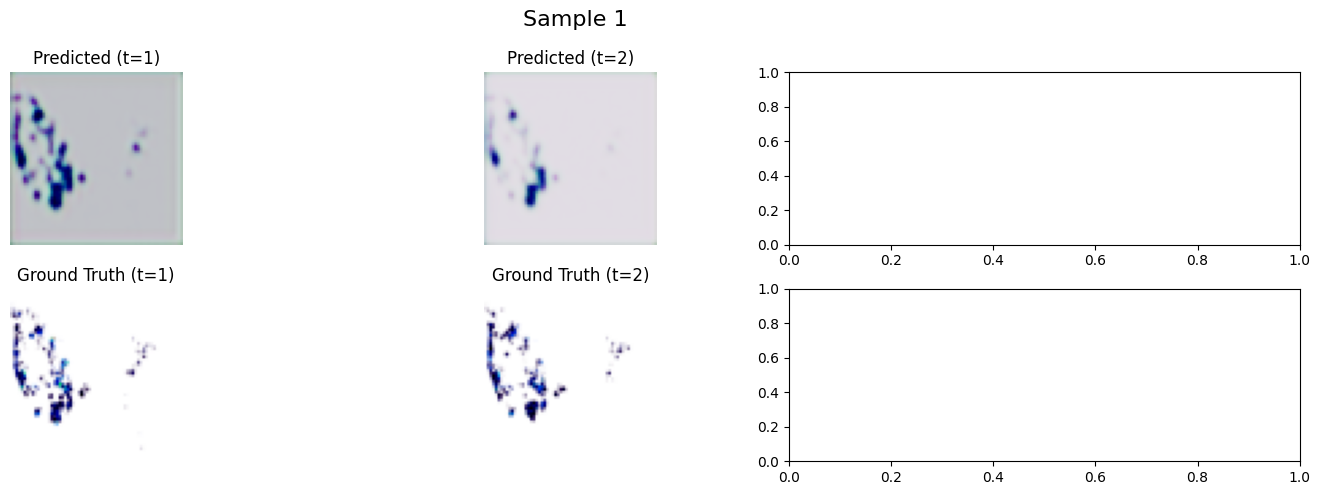

(3, 3, 64, 64)


(3, 3, 64, 64)


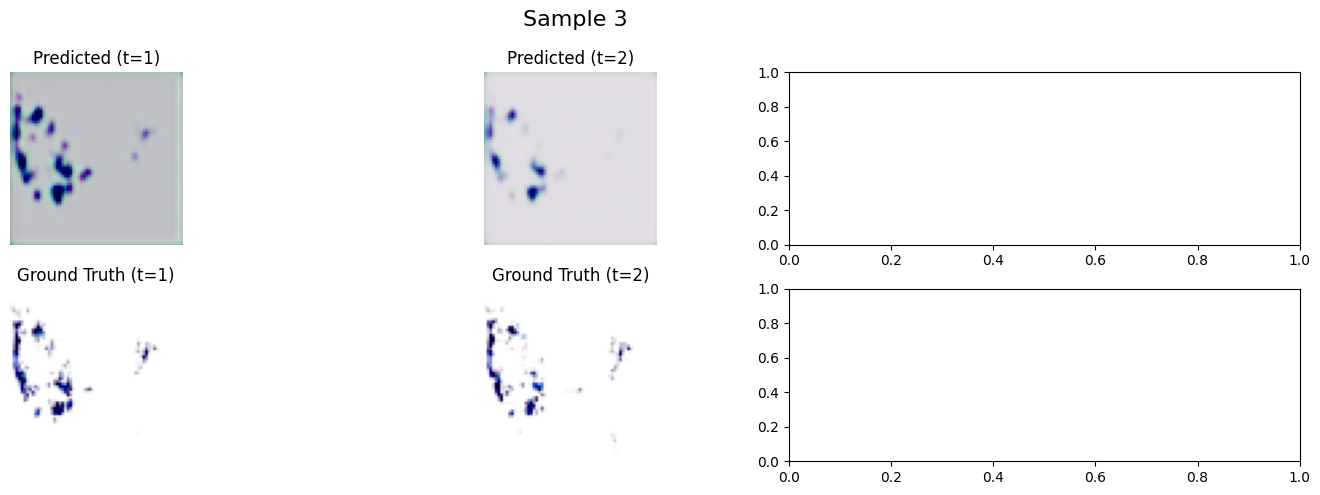

(3, 3, 64, 64)


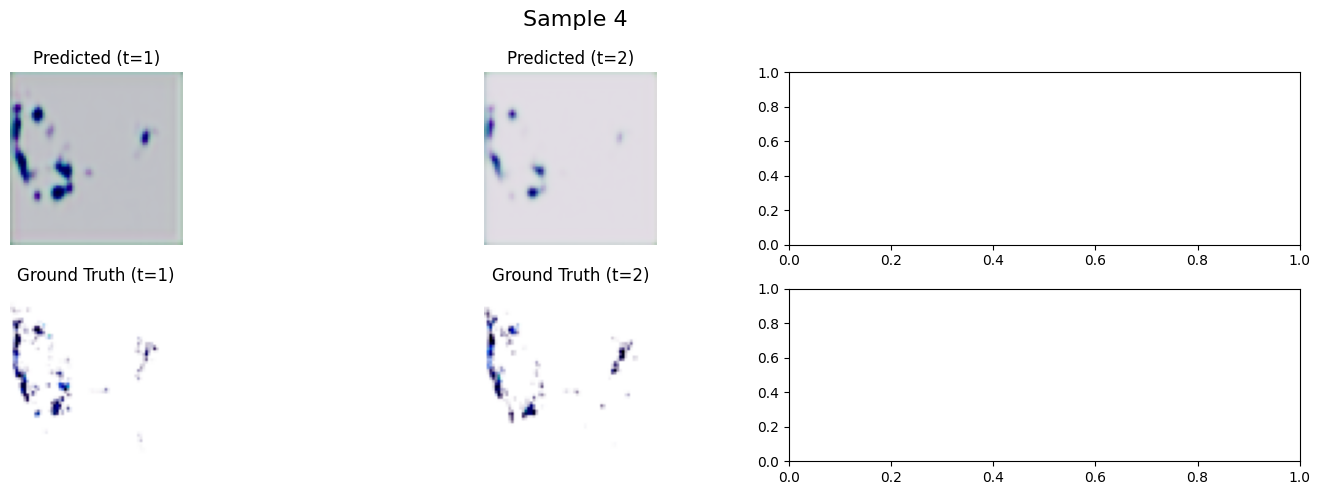

(3, 3, 64, 64)


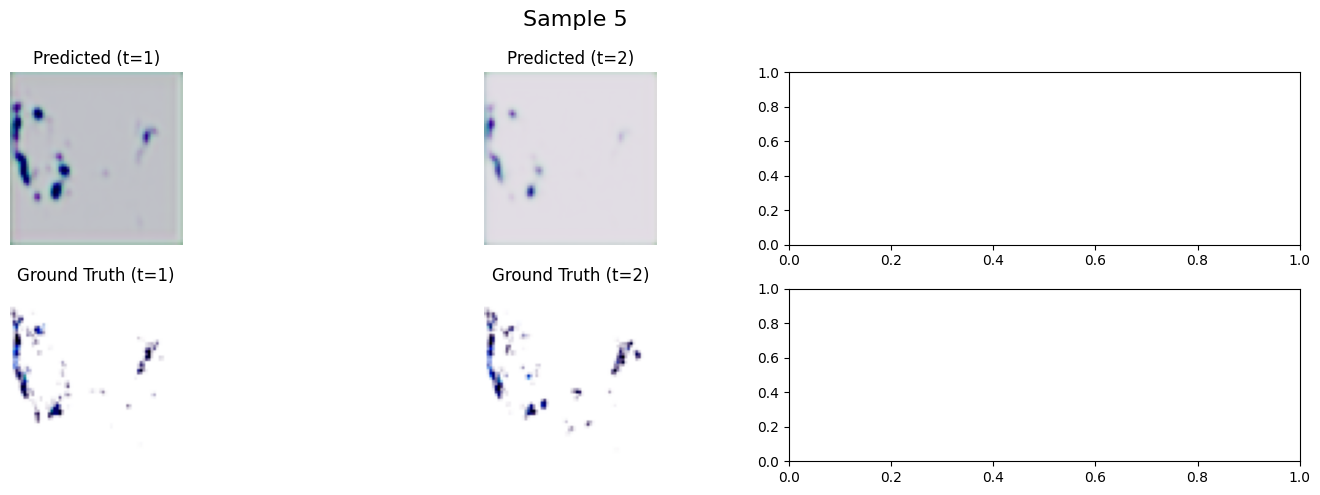

Epoch [1/10], Loss: 0.0078


Epoch [2/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:   3%|▎         | 1/37 [00:03<02:03,  3.42s/batch, loss=0.0832]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:   5%|▌         | 2/37 [00:04<01:04,  1.85s/batch, loss=0.0819]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:   8%|▊         | 3/37 [00:04<00:45,  1.35s/batch, loss=0.0804]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  11%|█         | 4/37 [00:05<00:36,  1.11s/batch, loss=0.0755]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  14%|█▎        | 5/37 [00:06<00:32,  1.01s/batch, loss=0.0746]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  16%|█▌        | 6/37 [00:07<00:28,  1.08batch/s, loss=0.0721]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  19%|█▉        | 7/37 [00:08<00:26,  1.14batch/s, loss=0.0697]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  22%|██▏       | 8/37 [00:08<00:24,  1.19batch/s, loss=0.073] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  24%|██▍       | 9/37 [00:09<00:24,  1.13batch/s, loss=0.0708]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  27%|██▋       | 10/37 [00:10<00:22,  1.18batch/s, loss=0.0675]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  30%|██▉       | 11/37 [00:11<00:21,  1.21batch/s, loss=0.0651]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  32%|███▏      | 12/37 [00:12<00:20,  1.24batch/s, loss=0.063] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  35%|███▌      | 13/37 [00:13<00:20,  1.16batch/s, loss=0.0612]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  38%|███▊      | 14/37 [00:13<00:19,  1.20batch/s, loss=0.06]  

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  41%|████      | 15/37 [00:14<00:17,  1.23batch/s, loss=0.0598]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  43%|████▎     | 16/37 [00:15<00:16,  1.26batch/s, loss=0.059] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  46%|████▌     | 17/37 [00:16<00:20,  1.01s/batch, loss=0.0597]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  49%|████▊     | 18/37 [00:17<00:17,  1.07batch/s, loss=0.0618]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  51%|█████▏    | 19/37 [00:18<00:15,  1.13batch/s, loss=0.0635]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  54%|█████▍    | 20/37 [00:19<00:14,  1.18batch/s, loss=0.0596]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  57%|█████▋    | 21/37 [00:20<00:14,  1.13batch/s, loss=0.0624]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  59%|█████▉    | 22/37 [00:20<00:12,  1.17batch/s, loss=0.0633]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  62%|██████▏   | 23/37 [00:21<00:11,  1.21batch/s, loss=0.0626]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  65%|██████▍   | 24/37 [00:22<00:10,  1.24batch/s, loss=0.0612]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  68%|██████▊   | 25/37 [00:23<00:10,  1.12batch/s, loss=0.0592]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  70%|███████   | 26/37 [00:24<00:09,  1.18batch/s, loss=0.0591]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  73%|███████▎  | 27/37 [00:25<00:08,  1.22batch/s, loss=0.0584]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  76%|███████▌  | 28/37 [00:25<00:07,  1.24batch/s, loss=0.058] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  78%|███████▊  | 29/37 [00:26<00:07,  1.12batch/s, loss=0.0592]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  81%|████████  | 30/37 [00:27<00:05,  1.17batch/s, loss=0.0601]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  84%|████████▍ | 31/37 [00:28<00:04,  1.21batch/s, loss=0.0624]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  86%|████████▋ | 32/37 [00:29<00:04,  1.24batch/s, loss=0.0588]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  89%|████████▉ | 33/37 [00:30<00:03,  1.19batch/s, loss=0.056] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.23batch/s, loss=0.0533]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.27batch/s, loss=0.054] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]:  97%|█████████▋| 36/37 [00:32<00:00,  1.29batch/s, loss=0.0583]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [2/10]: 100%|██████████| 37/37 [00:33<00:00,  1.11batch/s, loss=0.0556]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


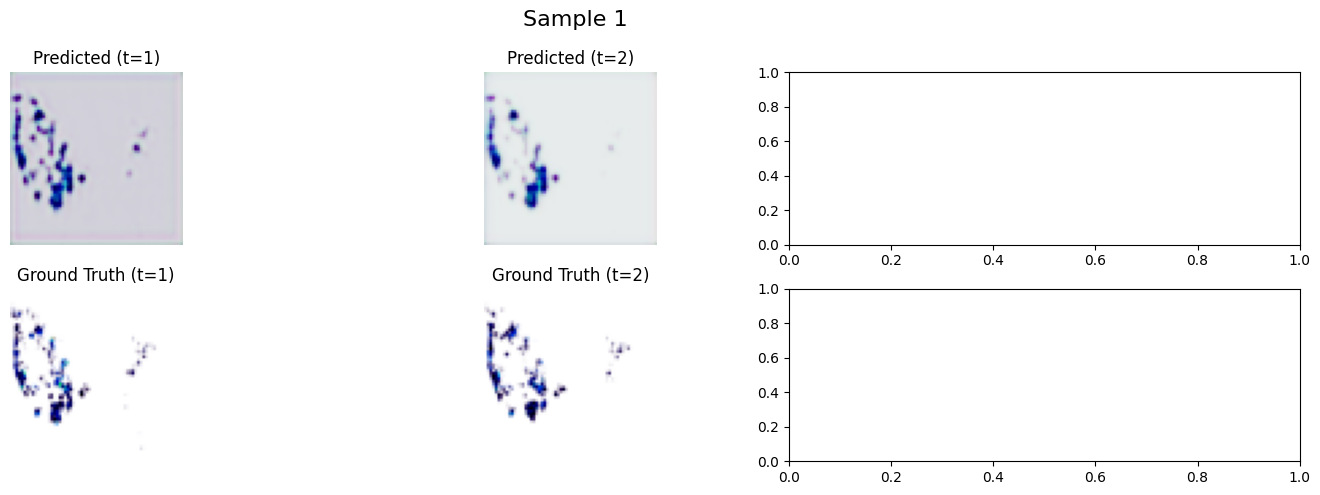

(3, 3, 64, 64)


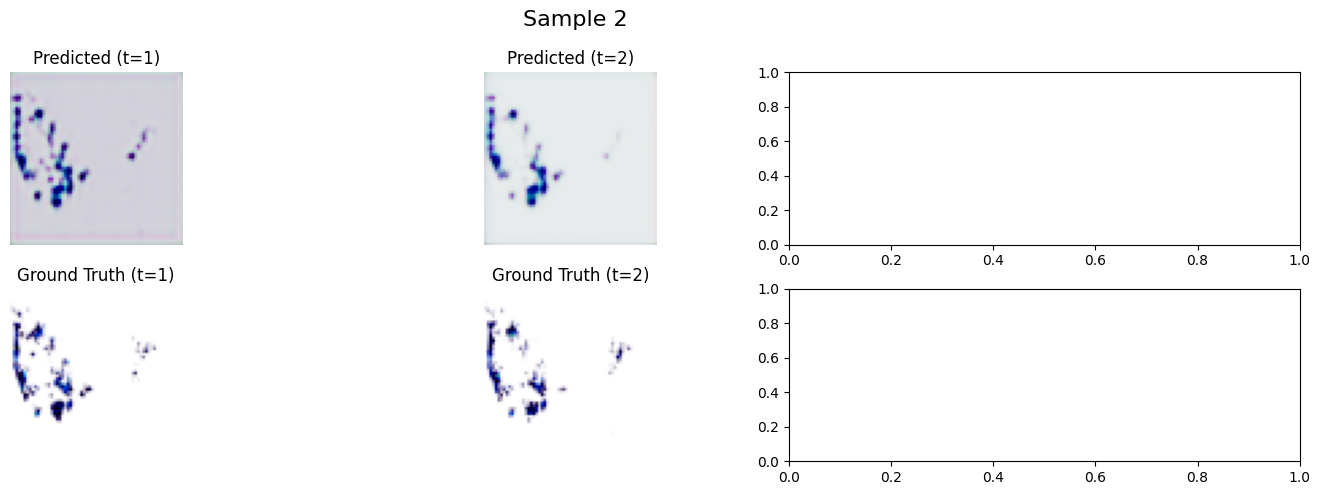

(3, 3, 64, 64)


(3, 3, 64, 64)


(3, 3, 64, 64)


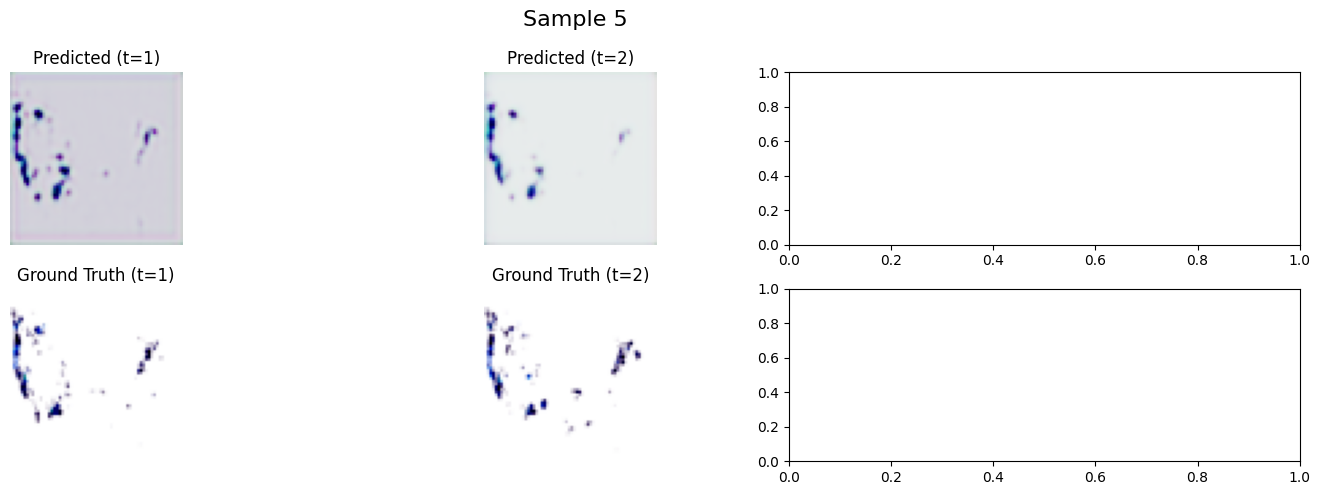

Epoch [2/10], Loss: 0.0052


Epoch [3/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:   3%|▎         | 1/37 [00:03<02:06,  3.50s/batch, loss=0.0551]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:   5%|▌         | 2/37 [00:04<01:06,  1.89s/batch, loss=0.0524]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:   8%|▊         | 3/37 [00:05<00:46,  1.37s/batch, loss=0.0521]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  11%|█         | 4/37 [00:05<00:37,  1.13s/batch, loss=0.0476]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  14%|█▎        | 5/37 [00:06<00:33,  1.05s/batch, loss=0.0479]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  16%|█▌        | 6/37 [00:07<00:29,  1.05batch/s, loss=0.0458]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  19%|█▉        | 7/37 [00:08<00:26,  1.13batch/s, loss=0.0441]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  22%|██▏       | 8/37 [00:08<00:24,  1.18batch/s, loss=0.0464]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  24%|██▍       | 9/37 [00:10<00:27,  1.04batch/s, loss=0.0455]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  27%|██▋       | 10/37 [00:10<00:24,  1.10batch/s, loss=0.0426]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  30%|██▉       | 11/37 [00:11<00:22,  1.16batch/s, loss=0.0418]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  32%|███▏      | 12/37 [00:12<00:20,  1.21batch/s, loss=0.04]  

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  35%|███▌      | 13/37 [00:13<00:21,  1.09batch/s, loss=0.0393]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  38%|███▊      | 14/37 [00:14<00:20,  1.15batch/s, loss=0.0392]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  41%|████      | 15/37 [00:15<00:18,  1.20batch/s, loss=0.0393]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  43%|████▎     | 16/37 [00:15<00:17,  1.23batch/s, loss=0.0389]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  46%|████▌     | 17/37 [00:16<00:18,  1.10batch/s, loss=0.0408]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  49%|████▊     | 18/37 [00:17<00:16,  1.16batch/s, loss=0.0437]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  51%|█████▏    | 19/37 [00:18<00:14,  1.21batch/s, loss=0.0441]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  54%|█████▍    | 20/37 [00:19<00:13,  1.23batch/s, loss=0.0403]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  57%|█████▋    | 21/37 [00:20<00:13,  1.19batch/s, loss=0.0441]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  59%|█████▉    | 22/37 [00:20<00:12,  1.23batch/s, loss=0.0416]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  62%|██████▏   | 23/37 [00:21<00:11,  1.26batch/s, loss=0.0406]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  65%|██████▍   | 24/37 [00:22<00:10,  1.28batch/s, loss=0.0436]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  68%|██████▊   | 25/37 [00:23<00:10,  1.15batch/s, loss=0.0426]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  70%|███████   | 26/37 [00:24<00:09,  1.20batch/s, loss=0.039] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  73%|███████▎  | 27/37 [00:25<00:08,  1.24batch/s, loss=0.0368]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  76%|███████▌  | 28/37 [00:25<00:07,  1.26batch/s, loss=0.0357]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  78%|███████▊  | 29/37 [00:26<00:06,  1.16batch/s, loss=0.0385]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  81%|████████  | 30/37 [00:27<00:05,  1.20batch/s, loss=0.0429]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  84%|████████▍ | 31/37 [00:28<00:04,  1.23batch/s, loss=0.0441]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  86%|████████▋ | 32/37 [00:29<00:03,  1.26batch/s, loss=0.0411]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  89%|████████▉ | 33/37 [00:30<00:03,  1.16batch/s, loss=0.0382]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.21batch/s, loss=0.0347]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.25batch/s, loss=0.0349]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]:  97%|█████████▋| 36/37 [00:32<00:00,  1.28batch/s, loss=0.0394]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [3/10]: 100%|██████████| 37/37 [00:33<00:00,  1.11batch/s, loss=0.0364]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


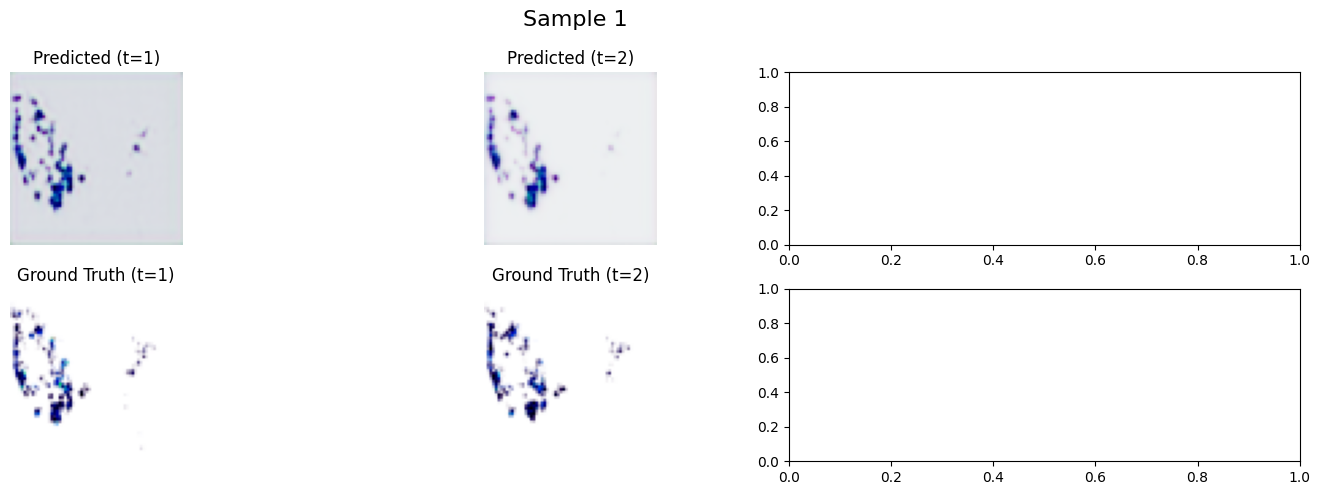

(3, 3, 64, 64)


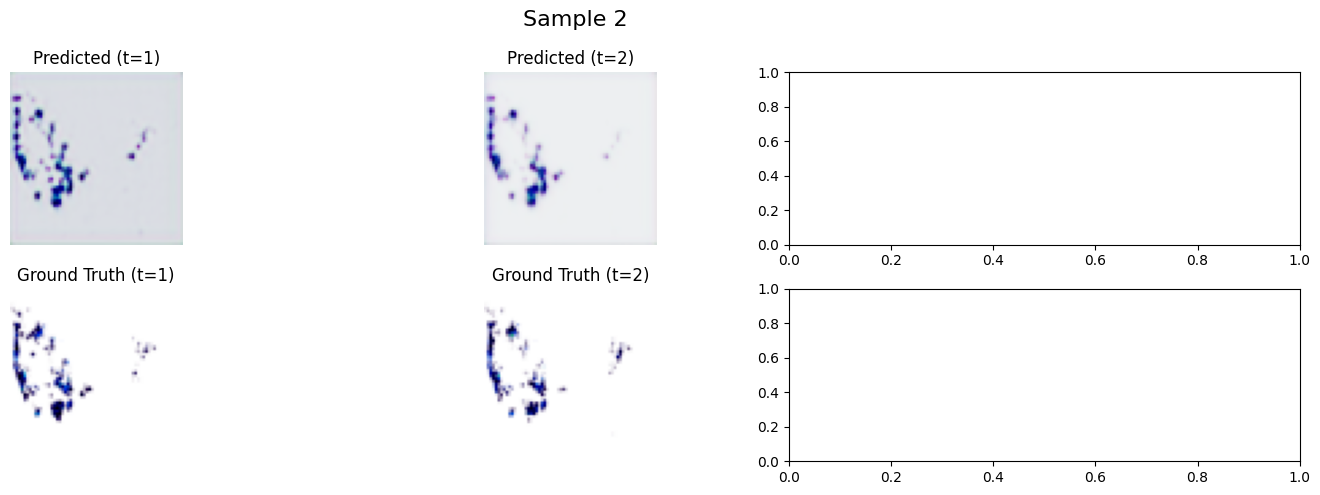

(3, 3, 64, 64)


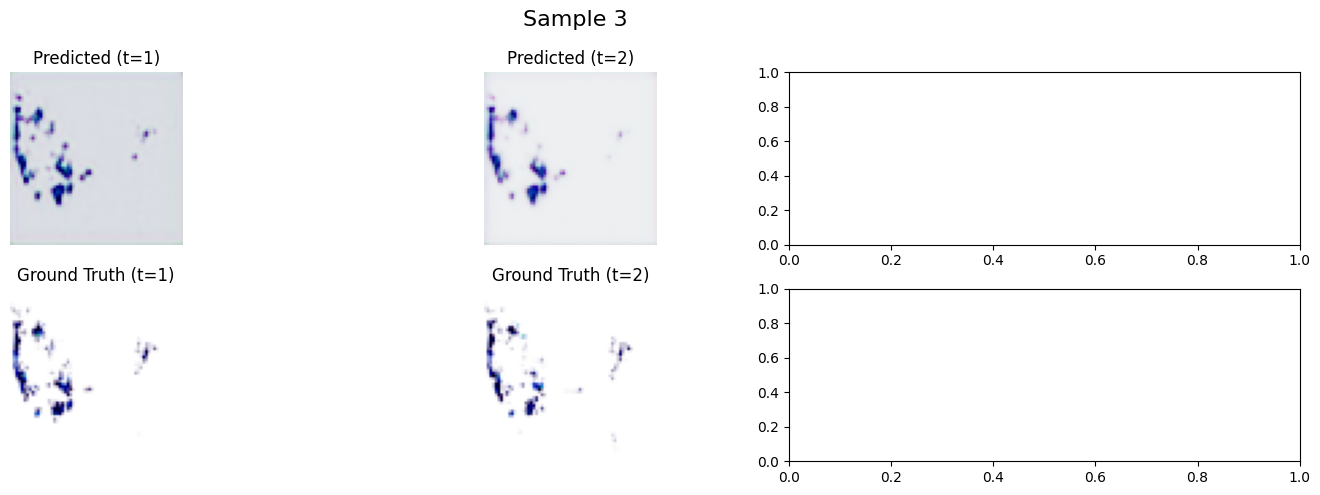

(3, 3, 64, 64)


(3, 3, 64, 64)


Epoch [3/10], Loss: 0.0040


Epoch [4/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:   3%|▎         | 1/37 [00:03<02:03,  3.44s/batch, loss=0.0337]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:   5%|▌         | 2/37 [00:04<01:05,  1.86s/batch, loss=0.035] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:   8%|▊         | 3/37 [00:04<00:46,  1.35s/batch, loss=0.0366]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  11%|█         | 4/37 [00:05<00:37,  1.14s/batch, loss=0.0316]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  14%|█▎        | 5/37 [00:06<00:36,  1.13s/batch, loss=0.0297]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  16%|█▌        | 6/37 [00:07<00:31,  1.01s/batch, loss=0.0281]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  19%|█▉        | 7/37 [00:08<00:27,  1.08batch/s, loss=0.0275]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  22%|██▏       | 8/37 [00:09<00:25,  1.15batch/s, loss=0.0312]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  24%|██▍       | 9/37 [00:10<00:27,  1.00batch/s, loss=0.0306]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  27%|██▋       | 10/37 [00:11<00:24,  1.08batch/s, loss=0.0273]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  30%|██▉       | 11/37 [00:11<00:22,  1.15batch/s, loss=0.0279]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  32%|███▏      | 12/37 [00:12<00:20,  1.20batch/s, loss=0.0266]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  35%|███▌      | 13/37 [00:13<00:20,  1.15batch/s, loss=0.0251]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  38%|███▊      | 14/37 [00:14<00:19,  1.20batch/s, loss=0.0266]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  41%|████      | 15/37 [00:15<00:17,  1.24batch/s, loss=0.028] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  43%|████▎     | 16/37 [00:15<00:16,  1.26batch/s, loss=0.0282]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  46%|████▌     | 17/37 [00:17<00:17,  1.12batch/s, loss=0.0307]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  49%|████▊     | 18/37 [00:17<00:16,  1.18batch/s, loss=0.0355]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  51%|█████▏    | 19/37 [00:18<00:14,  1.22batch/s, loss=0.0373]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  54%|█████▍    | 20/37 [00:19<00:13,  1.24batch/s, loss=0.032] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  57%|█████▋    | 21/37 [00:20<00:14,  1.10batch/s, loss=0.0357]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  59%|█████▉    | 22/37 [00:21<00:12,  1.16batch/s, loss=0.0343]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  62%|██████▏   | 23/37 [00:21<00:11,  1.21batch/s, loss=0.0344]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  65%|██████▍   | 24/37 [00:22<00:10,  1.24batch/s, loss=0.0354]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  68%|██████▊   | 25/37 [00:23<00:10,  1.13batch/s, loss=0.0361]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  70%|███████   | 26/37 [00:24<00:09,  1.19batch/s, loss=0.0316]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  73%|███████▎  | 27/37 [00:25<00:08,  1.22batch/s, loss=0.0292]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  76%|███████▌  | 28/37 [00:26<00:07,  1.25batch/s, loss=0.03]  

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  78%|███████▊  | 29/37 [00:27<00:07,  1.12batch/s, loss=0.0327]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  81%|████████  | 30/37 [00:27<00:05,  1.17batch/s, loss=0.0369]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  84%|████████▍ | 31/37 [00:28<00:04,  1.20batch/s, loss=0.0383]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  86%|████████▋ | 32/37 [00:29<00:04,  1.23batch/s, loss=0.0349]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  89%|████████▉ | 33/37 [00:30<00:03,  1.24batch/s, loss=0.0336]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.27batch/s, loss=0.0299]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.29batch/s, loss=0.03]  

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]:  97%|█████████▋| 36/37 [00:32<00:00,  1.31batch/s, loss=0.0349]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [4/10]: 100%|██████████| 37/37 [00:33<00:00,  1.11batch/s, loss=0.0337]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


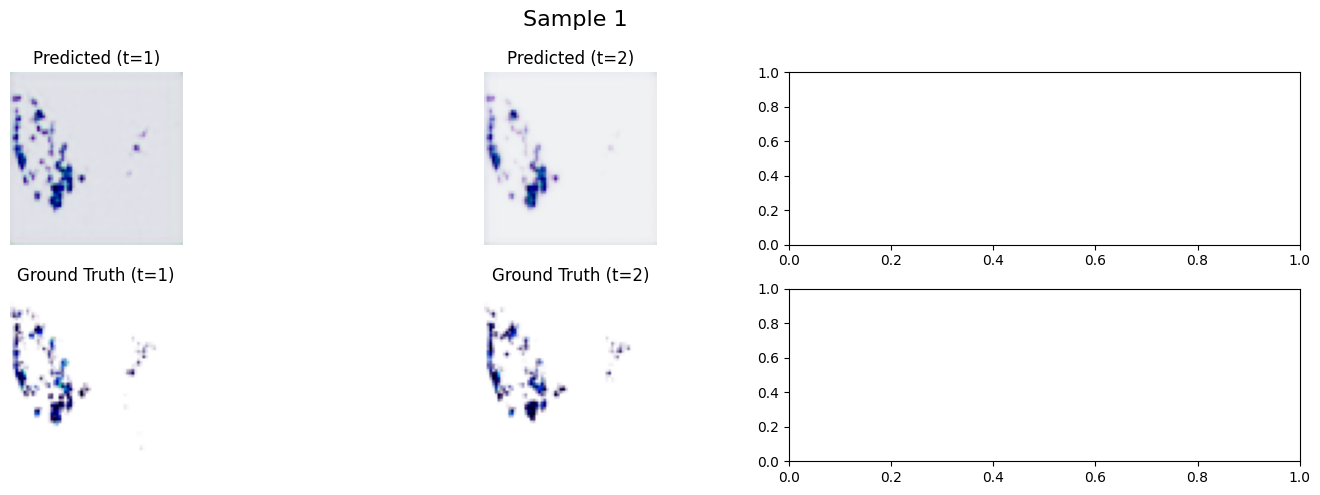

(3, 3, 64, 64)


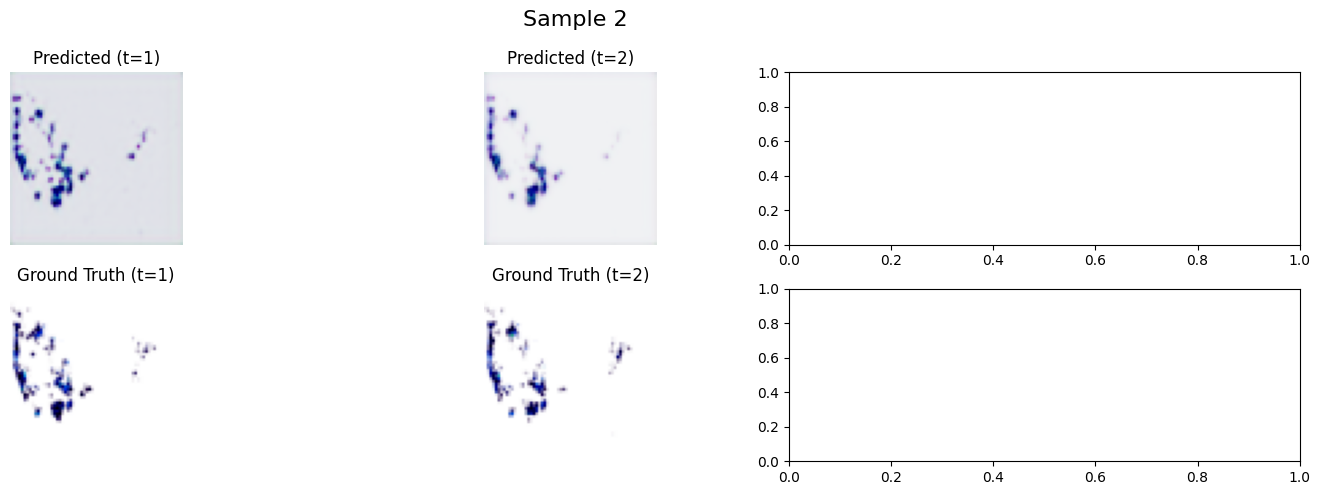

(3, 3, 64, 64)


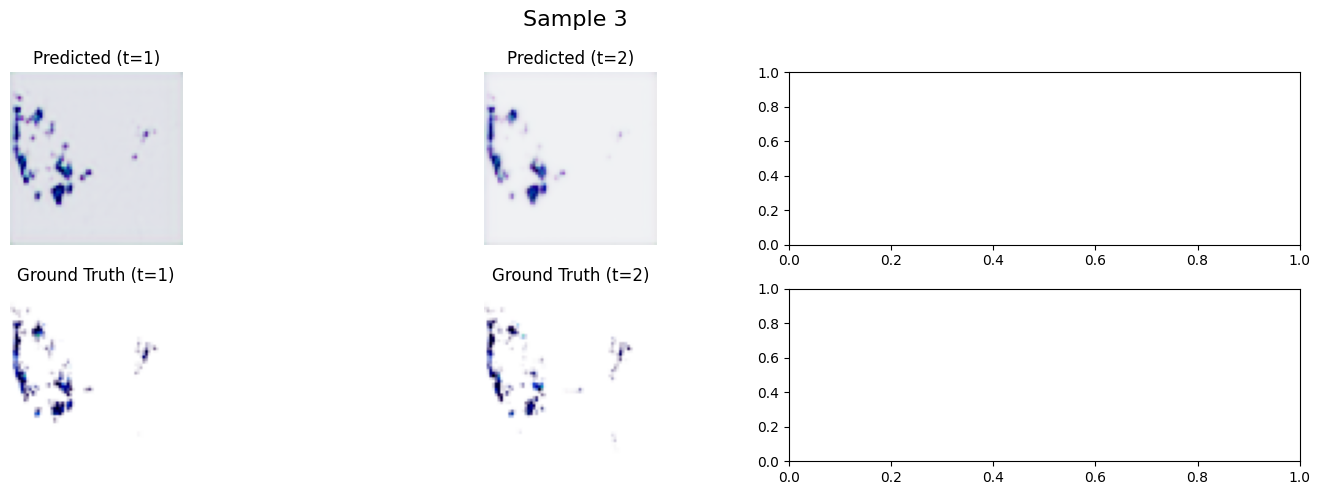

(3, 3, 64, 64)


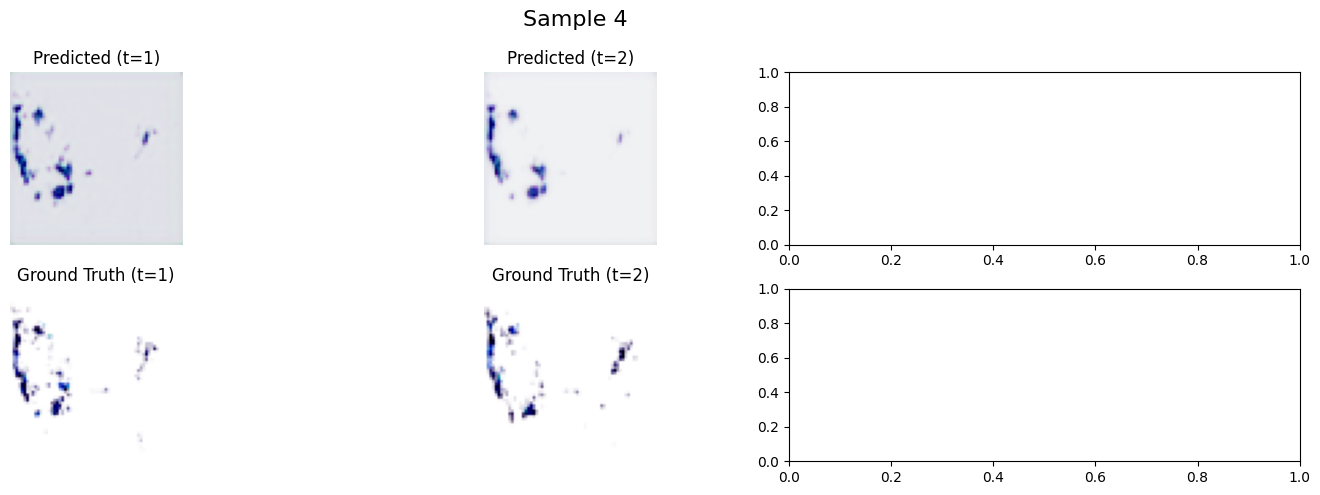

(3, 3, 64, 64)


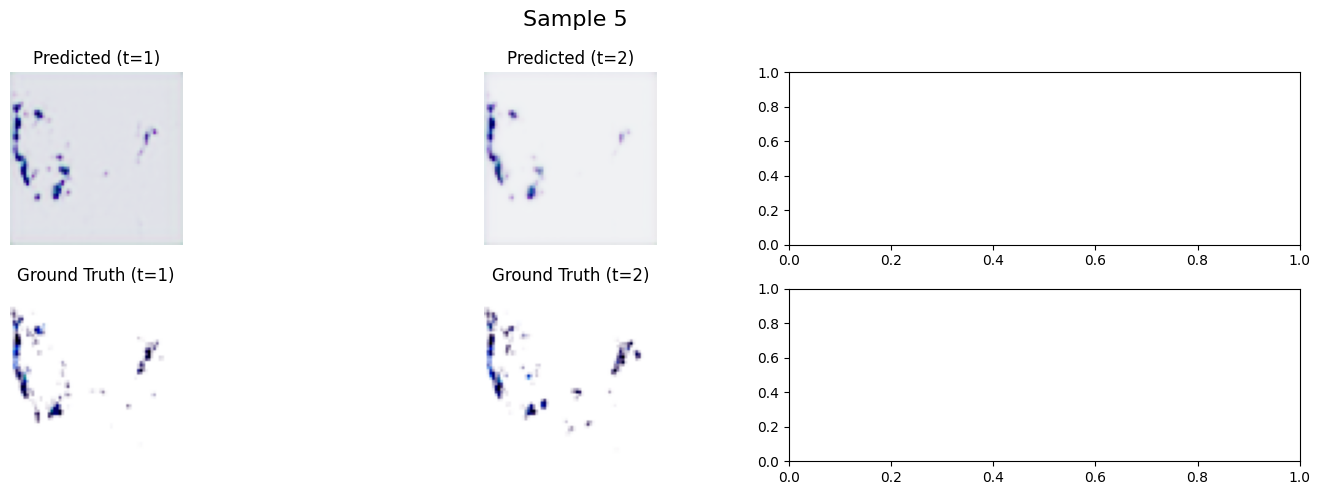

Epoch [4/10], Loss: 0.0037


Epoch [5/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:   3%|▎         | 1/37 [00:03<02:14,  3.75s/batch, loss=0.0305]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:   5%|▌         | 2/37 [00:04<01:09,  1.99s/batch, loss=0.0304]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:   8%|▊         | 3/37 [00:05<00:48,  1.43s/batch, loss=0.0313]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  11%|█         | 4/37 [00:06<00:38,  1.16s/batch, loss=0.0274]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  14%|█▎        | 5/37 [00:06<00:34,  1.08s/batch, loss=0.0259]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  16%|█▌        | 6/37 [00:07<00:30,  1.03batch/s, loss=0.0248]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  19%|█▉        | 7/37 [00:08<00:27,  1.11batch/s, loss=0.0241]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  22%|██▏       | 8/37 [00:09<00:24,  1.17batch/s, loss=0.0273]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  24%|██▍       | 9/37 [00:10<00:25,  1.09batch/s, loss=0.0268]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  27%|██▋       | 10/37 [00:11<00:23,  1.15batch/s, loss=0.0235]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  30%|██▉       | 11/37 [00:11<00:21,  1.20batch/s, loss=0.0233]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  32%|███▏      | 12/37 [00:12<00:20,  1.23batch/s, loss=0.0226]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  35%|███▌      | 13/37 [00:13<00:19,  1.23batch/s, loss=0.0217]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  38%|███▊      | 14/37 [00:14<00:18,  1.25batch/s, loss=0.0223]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  41%|████      | 15/37 [00:14<00:17,  1.27batch/s, loss=0.0232]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  43%|████▎     | 16/37 [00:15<00:16,  1.28batch/s, loss=0.0229]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  46%|████▌     | 17/37 [00:16<00:17,  1.16batch/s, loss=0.0262]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  49%|████▊     | 18/37 [00:17<00:15,  1.20batch/s, loss=0.0293]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  51%|█████▏    | 19/37 [00:18<00:14,  1.23batch/s, loss=0.0312]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  54%|█████▍    | 20/37 [00:19<00:13,  1.25batch/s, loss=0.0277]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  57%|█████▋    | 21/37 [00:20<00:13,  1.17batch/s, loss=0.0299]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  59%|█████▉    | 22/37 [00:20<00:12,  1.21batch/s, loss=0.0282]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  62%|██████▏   | 23/37 [00:21<00:11,  1.24batch/s, loss=0.0295]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  65%|██████▍   | 24/37 [00:22<00:10,  1.26batch/s, loss=0.0306]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  68%|██████▊   | 25/37 [00:23<00:10,  1.12batch/s, loss=0.0278]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  70%|███████   | 26/37 [00:24<00:09,  1.17batch/s, loss=0.0267]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  73%|███████▎  | 27/37 [00:24<00:08,  1.21batch/s, loss=0.0225]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  76%|███████▌  | 28/37 [00:25<00:07,  1.23batch/s, loss=0.0227]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  78%|███████▊  | 29/37 [00:26<00:06,  1.18batch/s, loss=0.0267]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  81%|████████  | 30/37 [00:27<00:05,  1.22batch/s, loss=0.0319]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  84%|████████▍ | 31/37 [00:28<00:04,  1.26batch/s, loss=0.033] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  86%|████████▋ | 32/37 [00:28<00:03,  1.27batch/s, loss=0.03] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  89%|████████▉ | 33/37 [00:30<00:03,  1.13batch/s, loss=0.0277]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.19batch/s, loss=0.0242]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.23batch/s, loss=0.0248]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]:  97%|█████████▋| 36/37 [00:32<00:00,  1.27batch/s, loss=0.0297]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [5/10]: 100%|██████████| 37/37 [00:33<00:00,  1.11batch/s, loss=0.0273]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


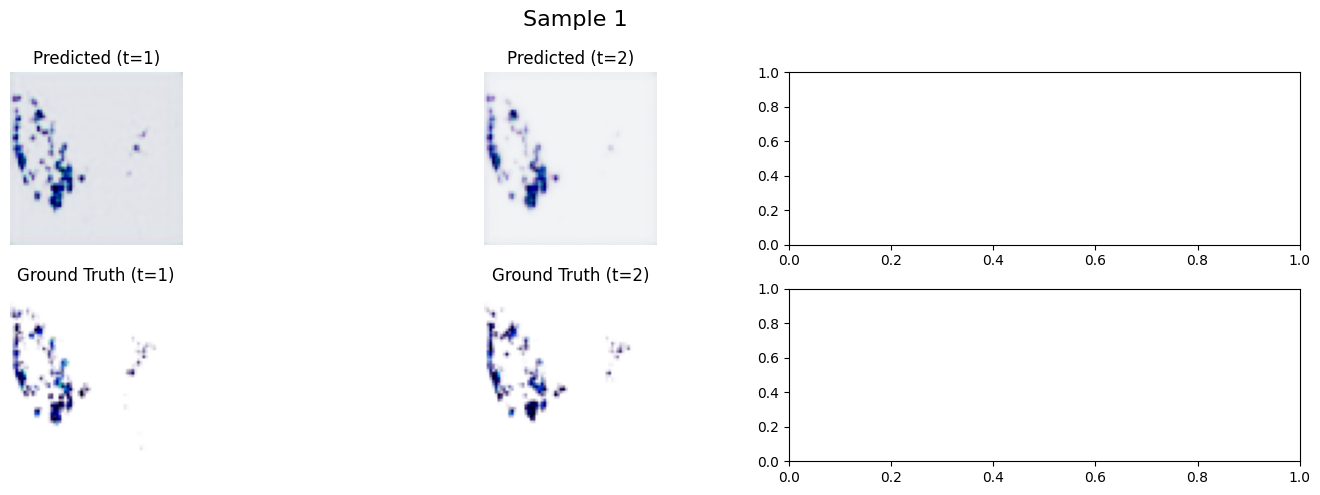

(3, 3, 64, 64)


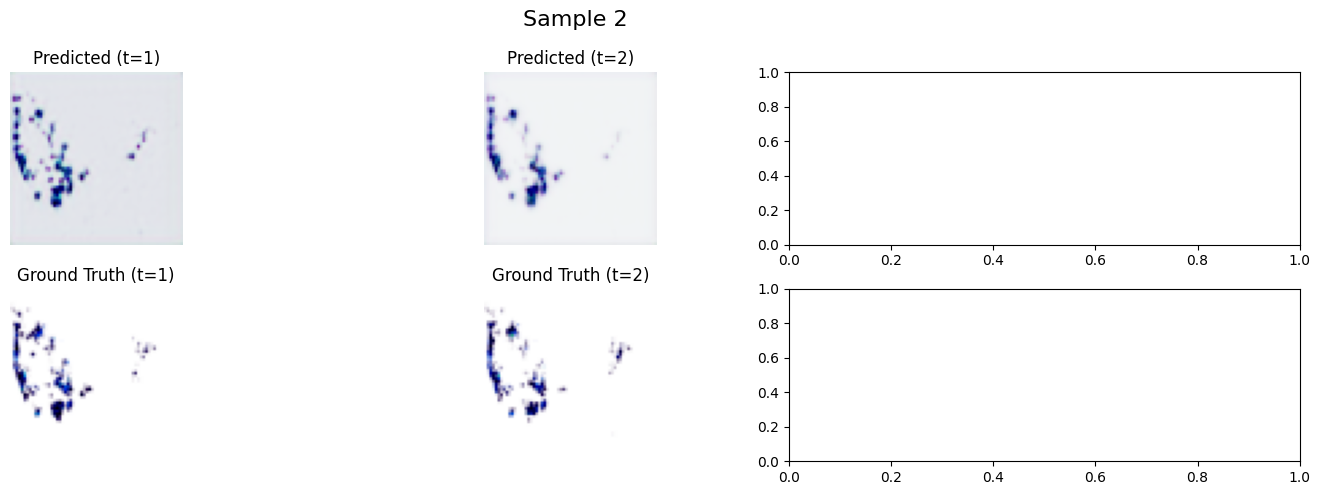

(3, 3, 64, 64)


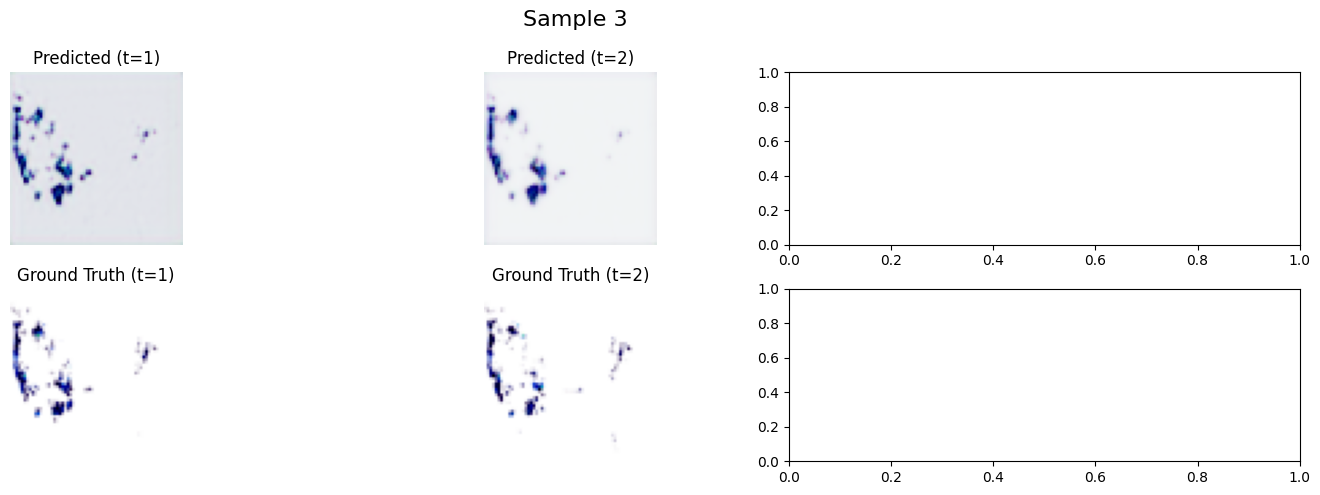

(3, 3, 64, 64)


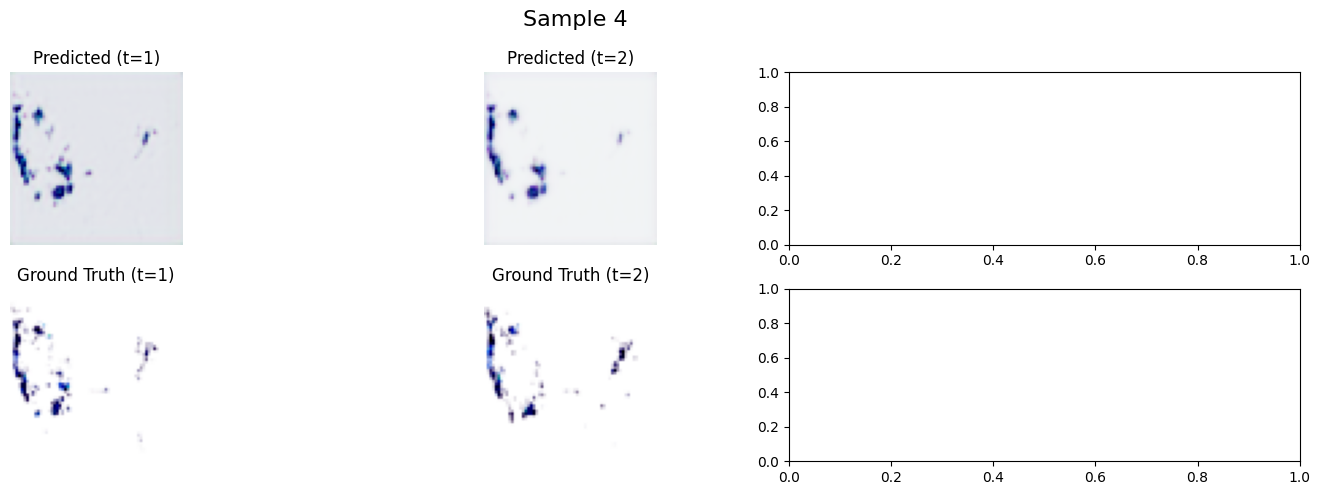

(3, 3, 64, 64)


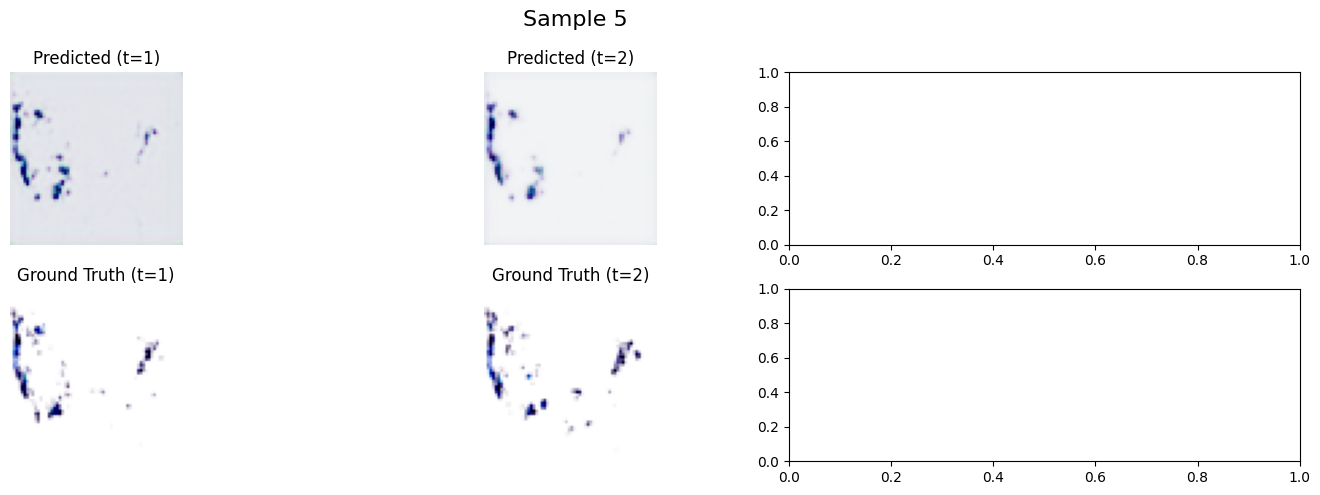

Epoch [5/10], Loss: 0.0032


Epoch [6/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:   3%|▎         | 1/37 [00:03<02:03,  3.43s/batch, loss=0.0247]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:   5%|▌         | 2/37 [00:04<01:05,  1.88s/batch, loss=0.0262]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:   8%|▊         | 3/37 [00:04<00:46,  1.36s/batch, loss=0.0271]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  11%|█         | 4/37 [00:05<00:37,  1.12s/batch, loss=0.0225]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  14%|█▎        | 5/37 [00:06<00:33,  1.04s/batch, loss=0.0198]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  16%|█▌        | 6/37 [00:07<00:29,  1.06batch/s, loss=0.019] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  19%|█▉        | 7/37 [00:08<00:26,  1.12batch/s, loss=0.0187]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  22%|██▏       | 8/37 [00:08<00:24,  1.18batch/s, loss=0.0227]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  24%|██▍       | 9/37 [00:09<00:25,  1.11batch/s, loss=0.0227]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  27%|██▋       | 10/37 [00:10<00:23,  1.17batch/s, loss=0.0193]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  30%|██▉       | 11/37 [00:11<00:21,  1.22batch/s, loss=0.019] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  32%|███▏      | 12/37 [00:12<00:20,  1.25batch/s, loss=0.0184]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  35%|███▌      | 13/37 [00:13<00:20,  1.18batch/s, loss=0.0175]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  38%|███▊      | 14/37 [00:13<00:19,  1.21batch/s, loss=0.0183]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  41%|████      | 15/37 [00:14<00:17,  1.23batch/s, loss=0.0196]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  43%|████▎     | 16/37 [00:15<00:16,  1.26batch/s, loss=0.0199]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  46%|████▌     | 17/37 [00:16<00:17,  1.14batch/s, loss=0.0229]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  49%|████▊     | 18/37 [00:17<00:15,  1.19batch/s, loss=0.0257]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  51%|█████▏    | 19/37 [00:18<00:14,  1.22batch/s, loss=0.0272]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  54%|█████▍    | 20/37 [00:18<00:13,  1.25batch/s, loss=0.0239]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  57%|█████▋    | 21/37 [00:19<00:13,  1.20batch/s, loss=0.0265]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  59%|█████▉    | 22/37 [00:20<00:12,  1.24batch/s, loss=0.0241]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  62%|██████▏   | 23/37 [00:21<00:11,  1.26batch/s, loss=0.025] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  65%|██████▍   | 24/37 [00:21<00:10,  1.28batch/s, loss=0.0271]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  68%|██████▊   | 25/37 [00:22<00:09,  1.22batch/s, loss=0.0245]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  70%|███████   | 26/37 [00:23<00:08,  1.24batch/s, loss=0.0232]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  73%|███████▎  | 27/37 [00:24<00:07,  1.25batch/s, loss=0.0197]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  76%|███████▌  | 28/37 [00:25<00:07,  1.27batch/s, loss=0.0197]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  78%|███████▊  | 29/37 [00:26<00:06,  1.20batch/s, loss=0.0235]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  81%|████████  | 30/37 [00:26<00:05,  1.23batch/s, loss=0.0297]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  84%|████████▍ | 31/37 [00:27<00:04,  1.26batch/s, loss=0.0307]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  86%|████████▋ | 32/37 [00:28<00:03,  1.27batch/s, loss=0.0281]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  89%|████████▉ | 33/37 [00:29<00:03,  1.12batch/s, loss=0.025] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.18batch/s, loss=0.0219]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.22batch/s, loss=0.0226]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]:  97%|█████████▋| 36/37 [00:31<00:00,  1.26batch/s, loss=0.0275]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [6/10]: 100%|██████████| 37/37 [00:32<00:00,  1.13batch/s, loss=0.0259]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


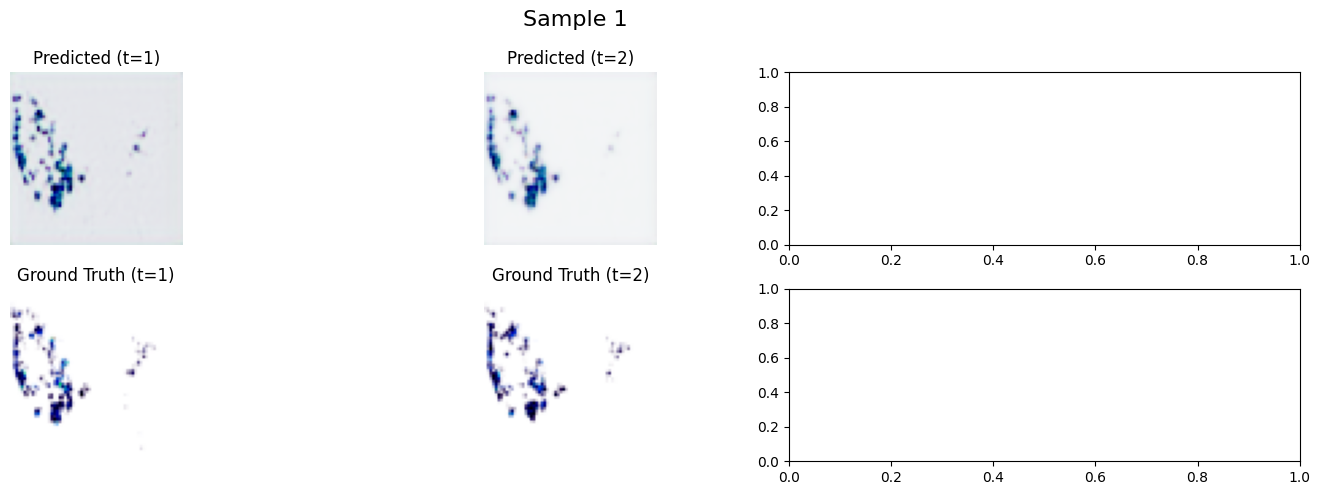

(3, 3, 64, 64)


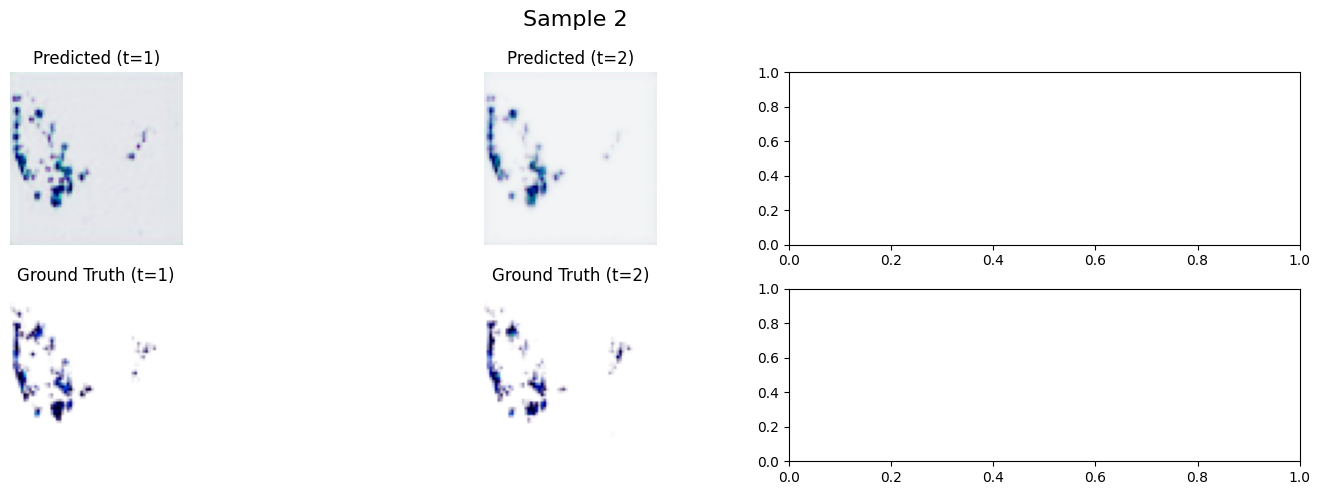

(3, 3, 64, 64)


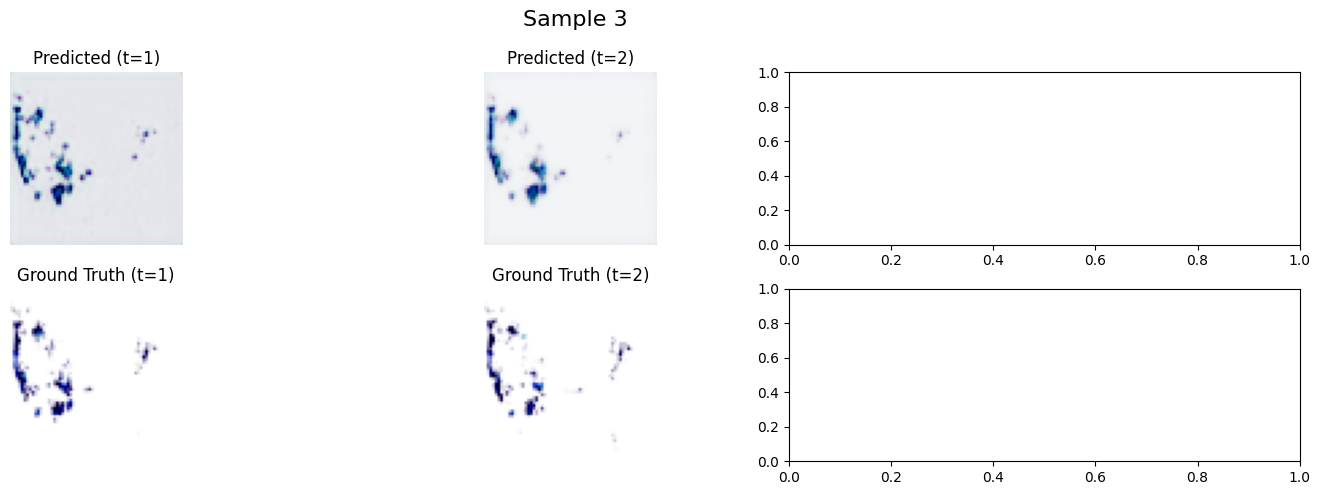

(3, 3, 64, 64)


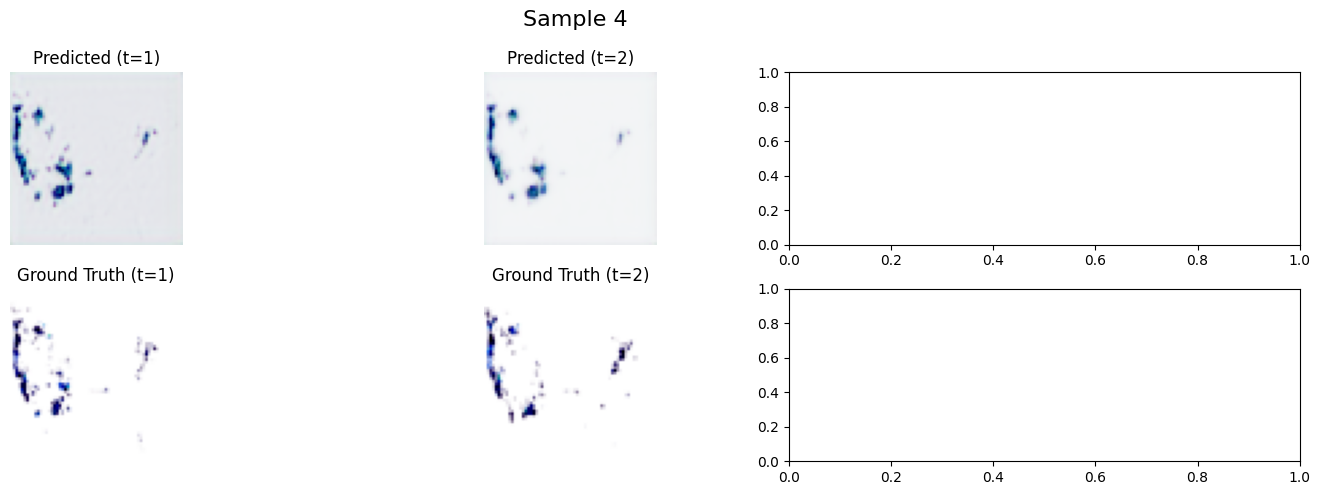

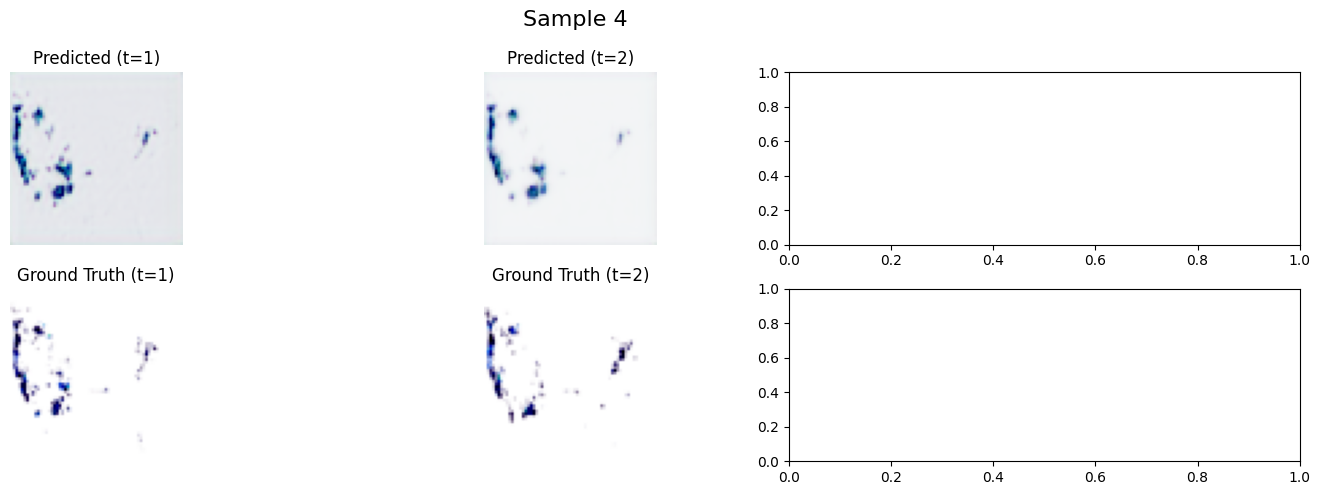

(3, 3, 64, 64)


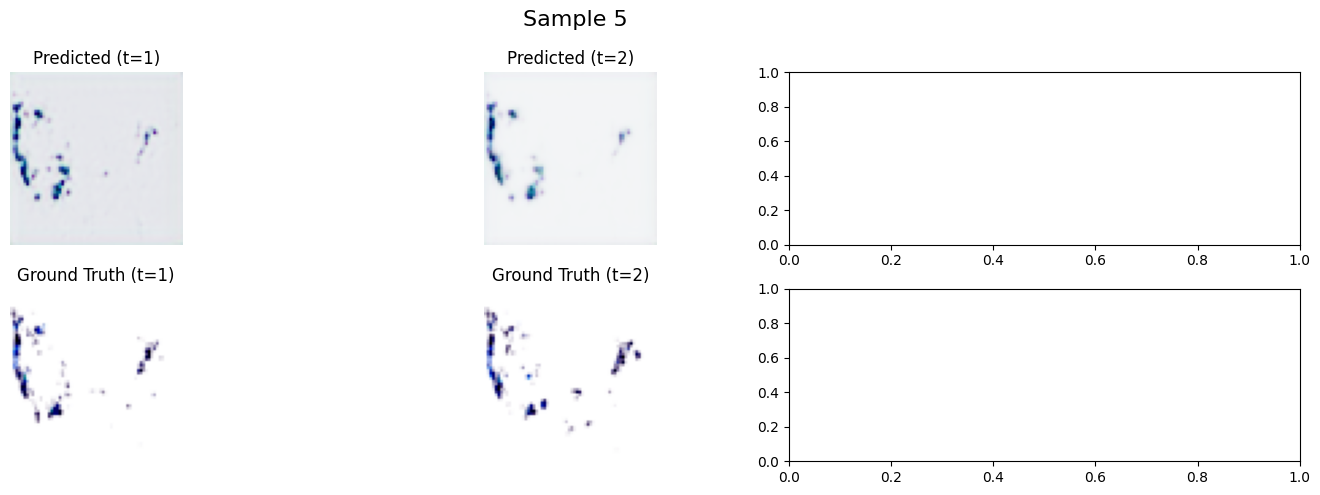

Epoch [6/10], Loss: 0.0030


Epoch [7/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:   3%|▎         | 1/37 [00:03<02:03,  3.44s/batch, loss=0.0217]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:   5%|▌         | 2/37 [00:04<01:05,  1.86s/batch, loss=0.0234]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:   8%|▊         | 3/37 [00:04<00:46,  1.35s/batch, loss=0.0249]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  11%|█         | 4/37 [00:05<00:36,  1.11s/batch, loss=0.0207]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  14%|█▎        | 5/37 [00:06<00:32,  1.03s/batch, loss=0.018] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  16%|█▌        | 6/37 [00:07<00:29,  1.06batch/s, loss=0.0173]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  19%|█▉        | 7/37 [00:08<00:26,  1.13batch/s, loss=0.0174]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  22%|██▏       | 8/37 [00:08<00:24,  1.19batch/s, loss=0.0211]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  24%|██▍       | 9/37 [00:09<00:25,  1.12batch/s, loss=0.0211]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  27%|██▋       | 10/37 [00:10<00:23,  1.17batch/s, loss=0.0176]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  30%|██▉       | 11/37 [00:11<00:21,  1.21batch/s, loss=0.0178]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  32%|███▏      | 12/37 [00:12<00:20,  1.23batch/s, loss=0.0173]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  35%|███▌      | 13/37 [00:12<00:19,  1.24batch/s, loss=0.0162]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  38%|███▊      | 14/37 [00:13<00:18,  1.26batch/s, loss=0.0168]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  41%|████      | 15/37 [00:14<00:17,  1.27batch/s, loss=0.0182]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  43%|████▎     | 16/37 [00:15<00:16,  1.29batch/s, loss=0.019] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  46%|████▌     | 17/37 [00:16<00:17,  1.15batch/s, loss=0.0224]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  49%|████▊     | 18/37 [00:17<00:15,  1.19batch/s, loss=0.0252]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  51%|█████▏    | 19/37 [00:17<00:14,  1.22batch/s, loss=0.0259]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  54%|█████▍    | 20/37 [00:18<00:13,  1.25batch/s, loss=0.0226]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  57%|█████▋    | 21/37 [00:19<00:14,  1.13batch/s, loss=0.025] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  59%|█████▉    | 22/37 [00:20<00:12,  1.17batch/s, loss=0.0225]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  62%|██████▏   | 23/37 [00:21<00:11,  1.22batch/s, loss=0.0236]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  65%|██████▍   | 24/37 [00:21<00:10,  1.25batch/s, loss=0.0255]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  68%|██████▊   | 25/37 [00:22<00:10,  1.19batch/s, loss=0.0232]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  70%|███████   | 26/37 [00:23<00:09,  1.22batch/s, loss=0.0208]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  73%|███████▎  | 27/37 [00:24<00:08,  1.25batch/s, loss=0.018] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  76%|███████▌  | 28/37 [00:25<00:07,  1.27batch/s, loss=0.0189]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  78%|███████▊  | 29/37 [00:26<00:07,  1.13batch/s, loss=0.0222]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  81%|████████  | 30/37 [00:27<00:05,  1.17batch/s, loss=0.0281]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  84%|████████▍ | 31/37 [00:27<00:04,  1.21batch/s, loss=0.0294]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  86%|████████▋ | 32/37 [00:28<00:04,  1.23batch/s, loss=0.0275]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  89%|████████▉ | 33/37 [00:30<00:04,  1.02s/batch, loss=0.0244]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.07batch/s, loss=0.0206]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.14batch/s, loss=0.0209]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]:  97%|█████████▋| 36/37 [00:32<00:00,  1.19batch/s, loss=0.0259]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [7/10]: 100%|██████████| 37/37 [00:33<00:00,  1.11batch/s, loss=0.0244]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


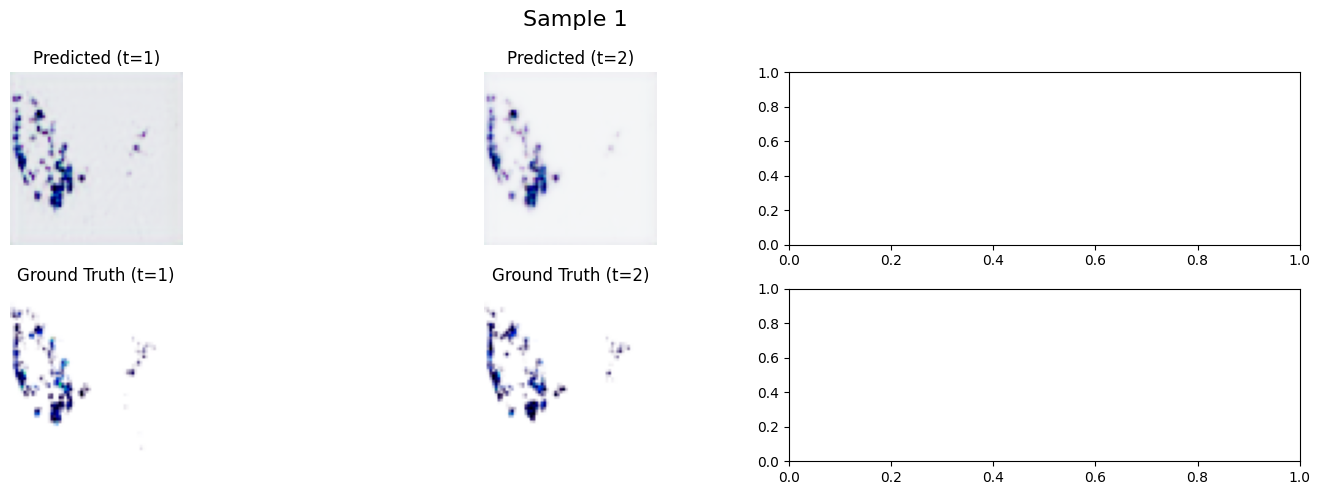

(3, 3, 64, 64)


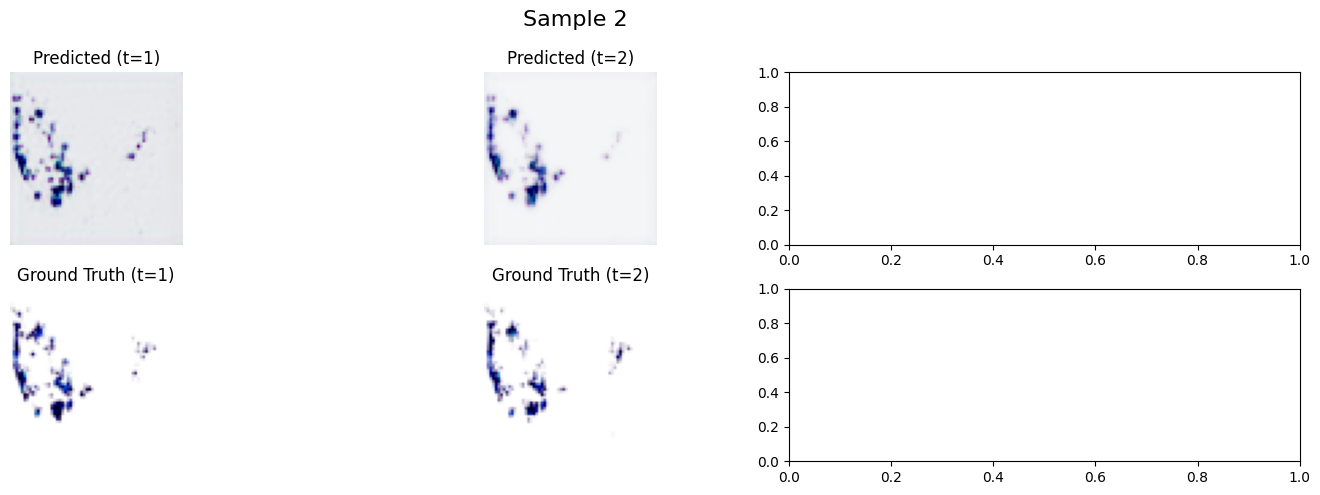

(3, 3, 64, 64)


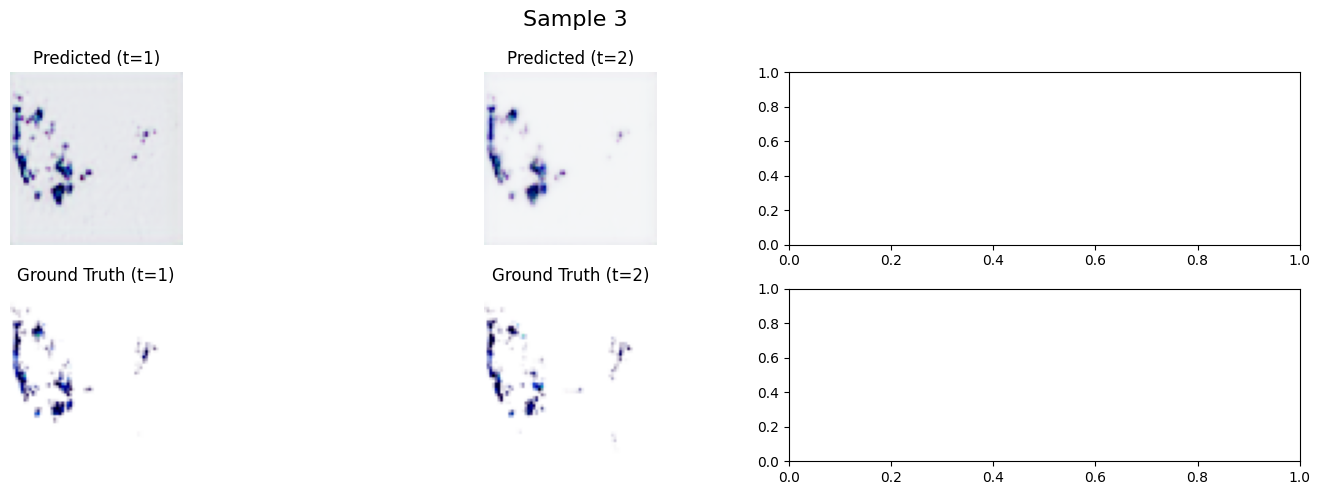

(3, 3, 64, 64)


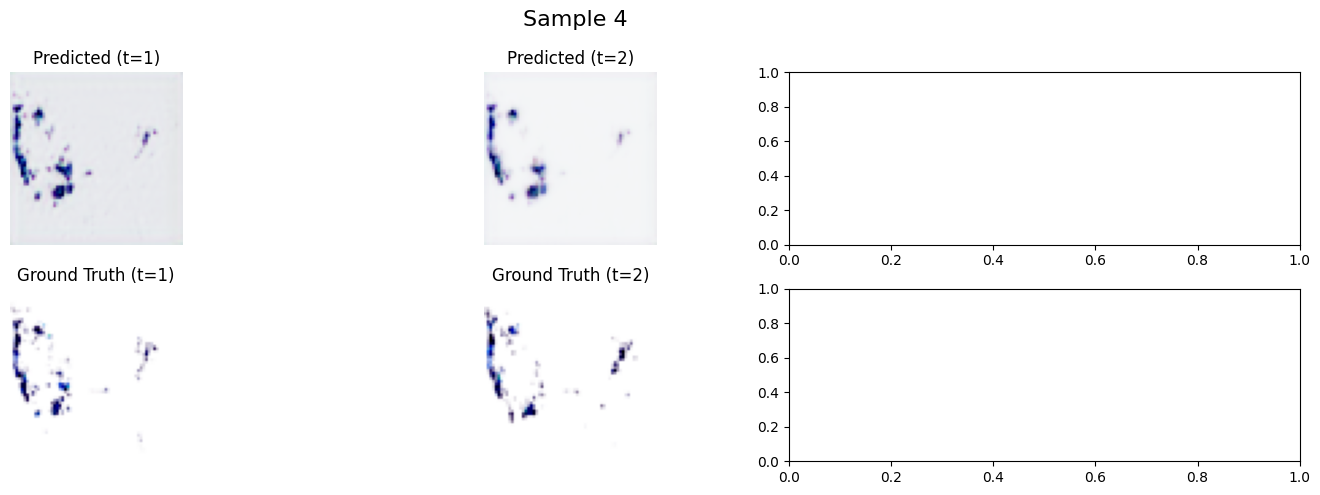

(3, 3, 64, 64)


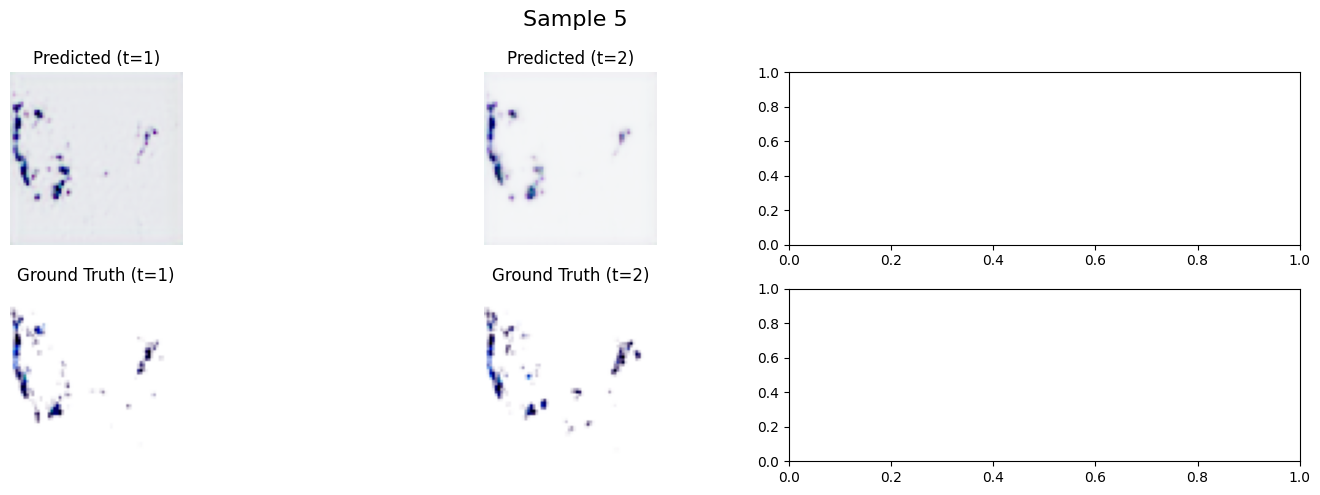

Epoch [7/10], Loss: 0.0027


Epoch [8/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:   3%|▎         | 1/37 [00:03<02:04,  3.46s/batch, loss=0.0196]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:   5%|▌         | 2/37 [00:04<01:06,  1.89s/batch, loss=0.0217]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:   8%|▊         | 3/37 [00:05<00:46,  1.37s/batch, loss=0.0225]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  11%|█         | 4/37 [00:05<00:37,  1.13s/batch, loss=0.0188]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  14%|█▎        | 5/37 [00:06<00:33,  1.04s/batch, loss=0.0165]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  16%|█▌        | 6/37 [00:07<00:29,  1.06batch/s, loss=0.0154]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  19%|█▉        | 7/37 [00:08<00:26,  1.13batch/s, loss=0.0153]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  22%|██▏       | 8/37 [00:08<00:24,  1.19batch/s, loss=0.0195]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  24%|██▍       | 9/37 [00:09<00:25,  1.11batch/s, loss=0.019] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  27%|██▋       | 10/37 [00:10<00:23,  1.17batch/s, loss=0.0161]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  30%|██▉       | 11/37 [00:11<00:21,  1.21batch/s, loss=0.0158]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  32%|███▏      | 12/37 [00:12<00:20,  1.24batch/s, loss=0.0153]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  35%|███▌      | 13/37 [00:12<00:19,  1.25batch/s, loss=0.0143]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  38%|███▊      | 14/37 [00:13<00:18,  1.27batch/s, loss=0.0151]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  41%|████      | 15/37 [00:14<00:17,  1.29batch/s, loss=0.0165]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  43%|████▎     | 16/37 [00:15<00:16,  1.29batch/s, loss=0.0168]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  46%|████▌     | 17/37 [00:16<00:17,  1.18batch/s, loss=0.0198]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  49%|████▊     | 18/37 [00:17<00:15,  1.22batch/s, loss=0.0226]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  51%|█████▏    | 19/37 [00:17<00:14,  1.25batch/s, loss=0.0237]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  54%|█████▍    | 20/37 [00:18<00:13,  1.27batch/s, loss=0.0203]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  57%|█████▋    | 21/37 [00:19<00:13,  1.17batch/s, loss=0.0231]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  59%|█████▉    | 22/37 [00:20<00:12,  1.21batch/s, loss=0.0207]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  62%|██████▏   | 23/37 [00:21<00:11,  1.24batch/s, loss=0.0209]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  65%|██████▍   | 24/37 [00:21<00:10,  1.26batch/s, loss=0.0231]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  68%|██████▊   | 25/37 [00:22<00:10,  1.19batch/s, loss=0.0212]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  70%|███████   | 26/37 [00:23<00:09,  1.21batch/s, loss=0.019] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  73%|███████▎  | 27/37 [00:24<00:08,  1.23batch/s, loss=0.0165]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  76%|███████▌  | 28/37 [00:25<00:07,  1.25batch/s, loss=0.0164]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  78%|███████▊  | 29/37 [00:26<00:07,  1.04batch/s, loss=0.02]  

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  81%|████████  | 30/37 [00:27<00:06,  1.10batch/s, loss=0.0265]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  84%|████████▍ | 31/37 [00:28<00:05,  1.16batch/s, loss=0.0271]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  86%|████████▋ | 32/37 [00:28<00:04,  1.20batch/s, loss=0.025] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  89%|████████▉ | 33/37 [00:29<00:03,  1.12batch/s, loss=0.0225]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.18batch/s, loss=0.0199]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.23batch/s, loss=0.0204]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]:  97%|█████████▋| 36/37 [00:32<00:00,  1.26batch/s, loss=0.0241]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [8/10]: 100%|██████████| 37/37 [00:33<00:00,  1.12batch/s, loss=0.0226]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


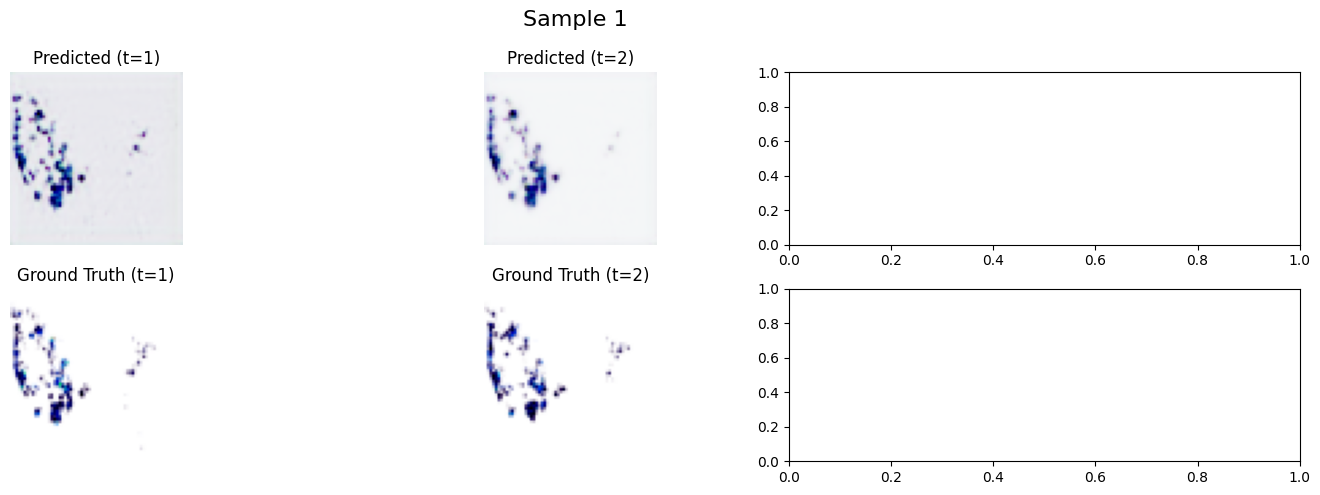

(3, 3, 64, 64)


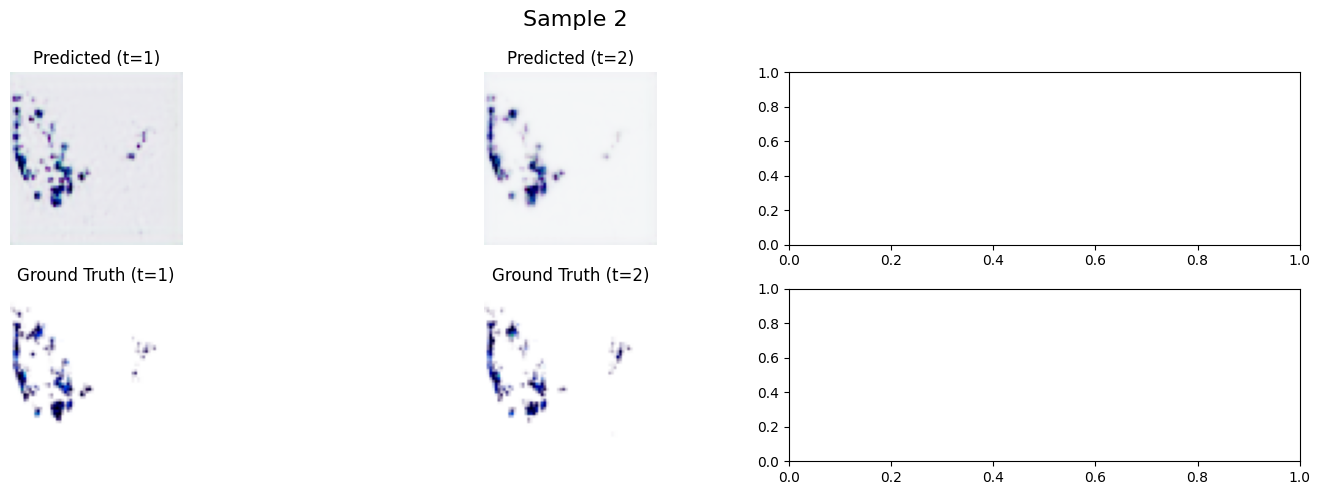

(3, 3, 64, 64)


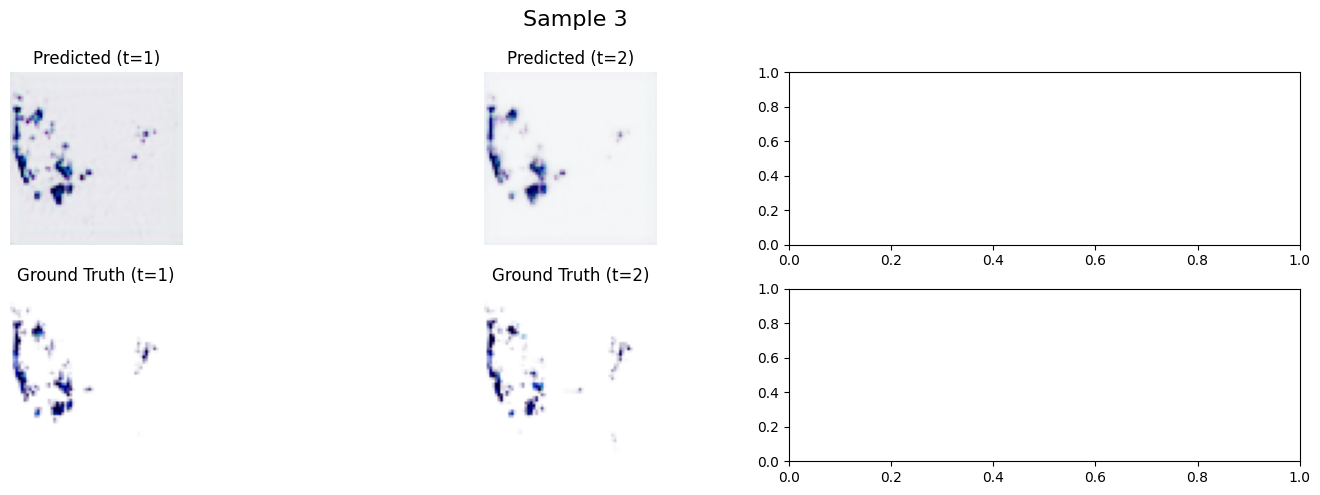

(3, 3, 64, 64)


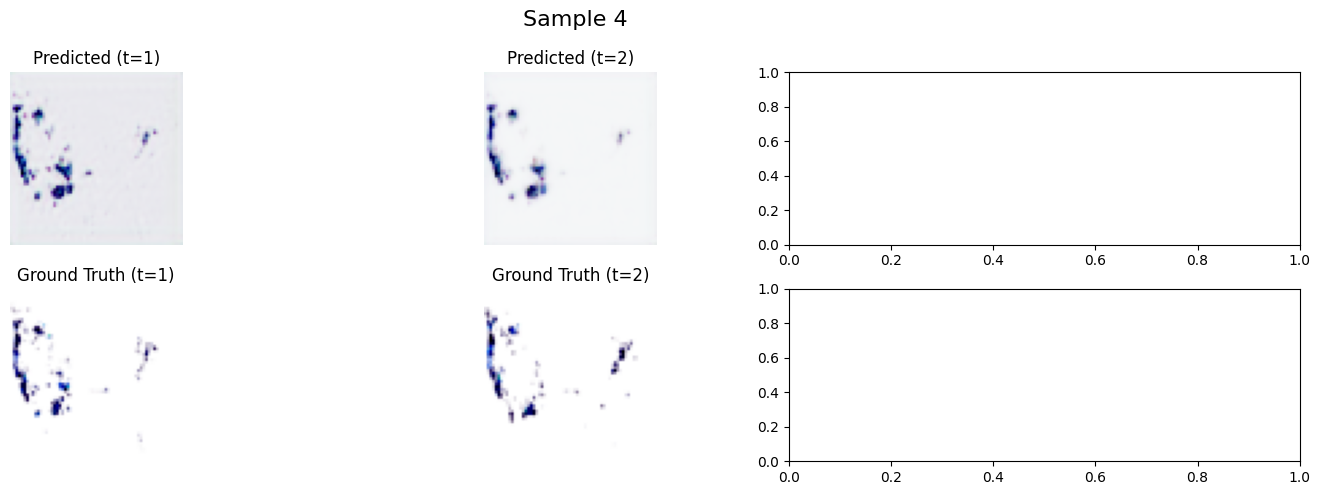

(3, 3, 64, 64)


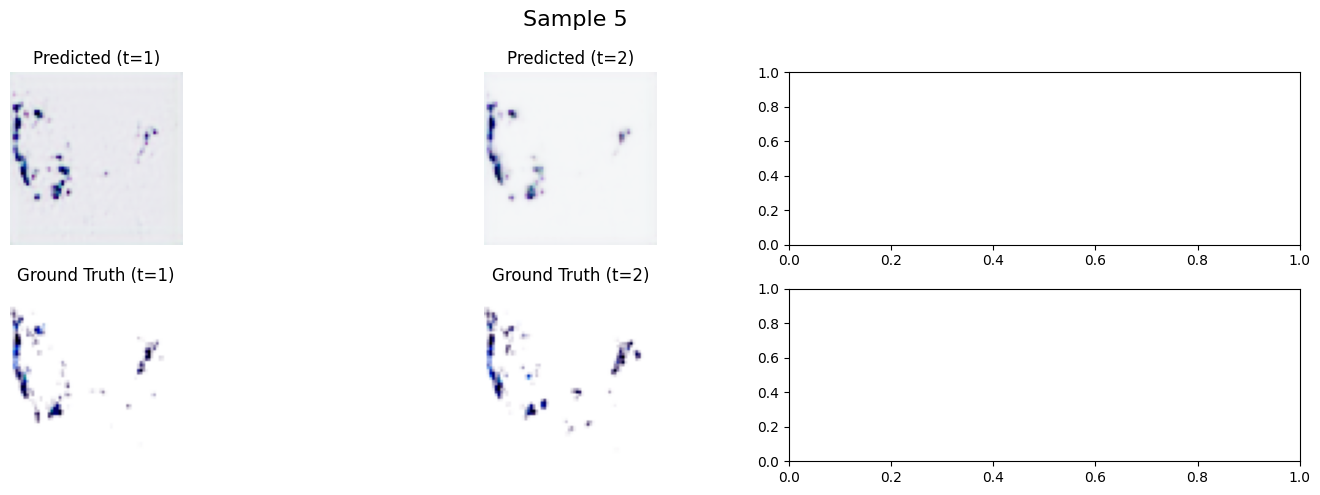

Epoch [8/10], Loss: 0.0025


Epoch [9/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:   3%|▎         | 1/37 [00:03<02:03,  3.43s/batch, loss=0.0181]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:   5%|▌         | 2/37 [00:04<01:05,  1.86s/batch, loss=0.0208]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:   8%|▊         | 3/37 [00:04<00:46,  1.36s/batch, loss=0.022] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  11%|█         | 4/37 [00:05<00:36,  1.12s/batch, loss=0.0177]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  14%|█▎        | 5/37 [00:06<00:34,  1.07s/batch, loss=0.0155]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  16%|█▌        | 6/37 [00:07<00:29,  1.04batch/s, loss=0.0146]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  19%|█▉        | 7/37 [00:08<00:27,  1.11batch/s, loss=0.0144]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  22%|██▏       | 8/37 [00:08<00:24,  1.17batch/s, loss=0.0185]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  24%|██▍       | 9/37 [00:10<00:25,  1.09batch/s, loss=0.0182]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  27%|██▋       | 10/37 [00:10<00:23,  1.14batch/s, loss=0.0152]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  30%|██▉       | 11/37 [00:11<00:21,  1.19batch/s, loss=0.015] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  32%|███▏      | 12/37 [00:12<00:20,  1.23batch/s, loss=0.0141]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  35%|███▌      | 13/37 [00:13<00:20,  1.16batch/s, loss=0.0126]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  38%|███▊      | 14/37 [00:14<00:19,  1.21batch/s, loss=0.0135]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  41%|████      | 15/37 [00:14<00:17,  1.24batch/s, loss=0.0154]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  43%|████▎     | 16/37 [00:15<00:16,  1.26batch/s, loss=0.0154]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  46%|████▌     | 17/37 [00:16<00:16,  1.21batch/s, loss=0.0184]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  49%|████▊     | 18/37 [00:17<00:15,  1.23batch/s, loss=0.0212]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  51%|█████▏    | 19/37 [00:18<00:14,  1.25batch/s, loss=0.0224]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  54%|█████▍    | 20/37 [00:18<00:13,  1.28batch/s, loss=0.019] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  57%|█████▋    | 21/37 [00:19<00:13,  1.17batch/s, loss=0.022]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  59%|█████▉    | 22/37 [00:20<00:12,  1.20batch/s, loss=0.0198]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  62%|██████▏   | 23/37 [00:21<00:11,  1.21batch/s, loss=0.0199]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  65%|██████▍   | 24/37 [00:22<00:10,  1.24batch/s, loss=0.0221]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  68%|██████▊   | 25/37 [00:23<00:11,  1.03batch/s, loss=0.0201]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  70%|███████   | 26/37 [00:24<00:10,  1.10batch/s, loss=0.0182]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  73%|███████▎  | 27/37 [00:25<00:08,  1.16batch/s, loss=0.0158]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  76%|███████▌  | 28/37 [00:25<00:07,  1.20batch/s, loss=0.0161]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  78%|███████▊  | 29/37 [00:26<00:06,  1.17batch/s, loss=0.0195]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  81%|████████  | 30/37 [00:27<00:05,  1.20batch/s, loss=0.0249]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  84%|████████▍ | 31/37 [00:28<00:04,  1.23batch/s, loss=0.0258]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  86%|████████▋ | 32/37 [00:28<00:03,  1.26batch/s, loss=0.0242]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  89%|████████▉ | 33/37 [00:30<00:03,  1.14batch/s, loss=0.0213]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.19batch/s, loss=0.0182]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.24batch/s, loss=0.0194]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]:  97%|█████████▋| 36/37 [00:32<00:00,  1.27batch/s, loss=0.0237]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [9/10]: 100%|██████████| 37/37 [00:33<00:00,  1.11batch/s, loss=0.0217]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


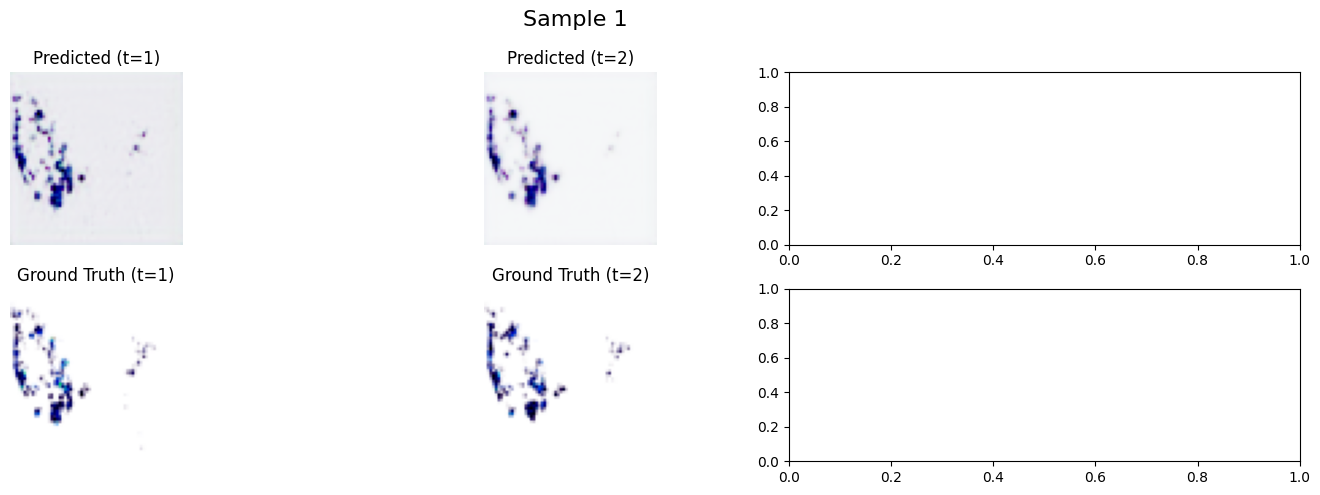

(3, 3, 64, 64)


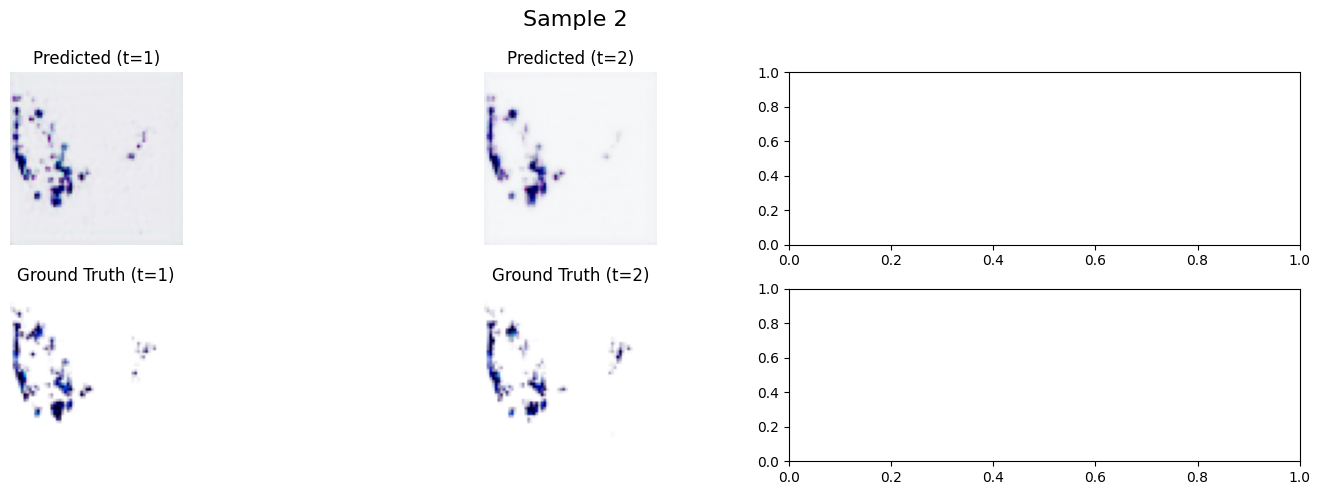

(3, 3, 64, 64)


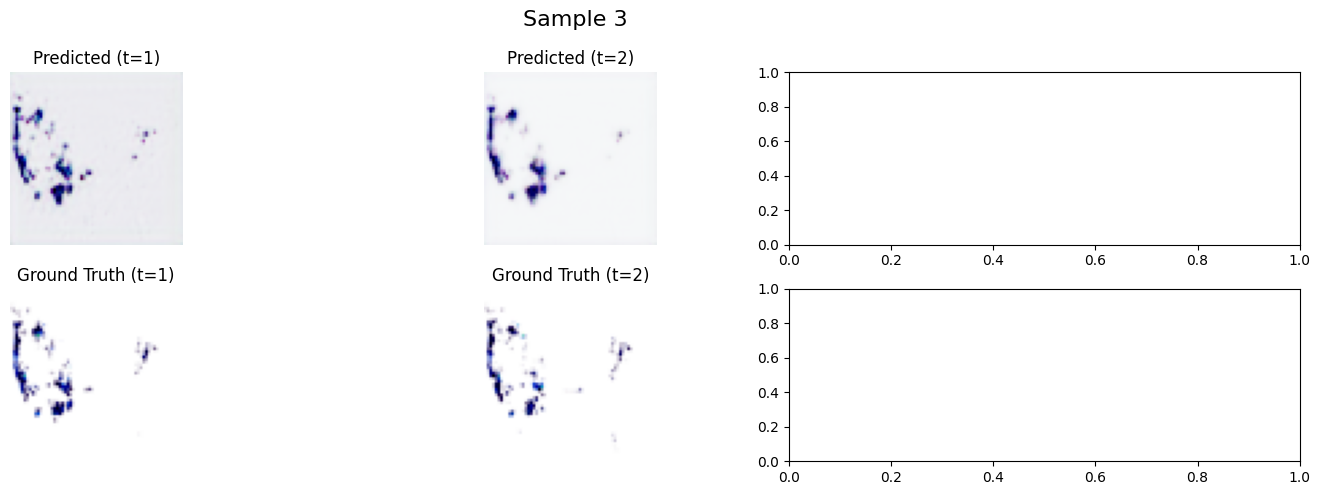

(3, 3, 64, 64)


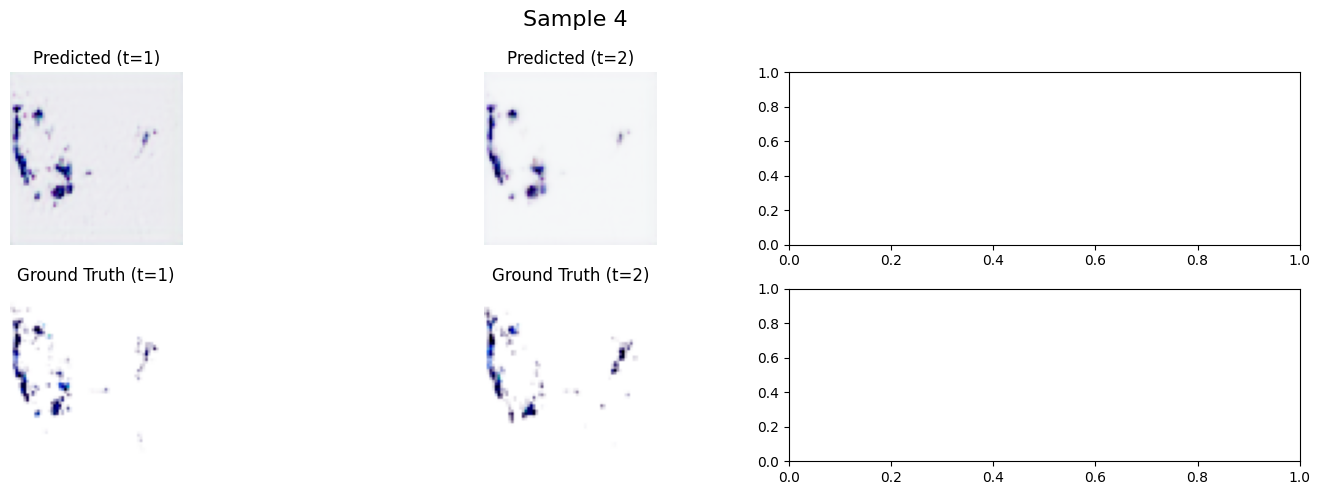

(3, 3, 64, 64)


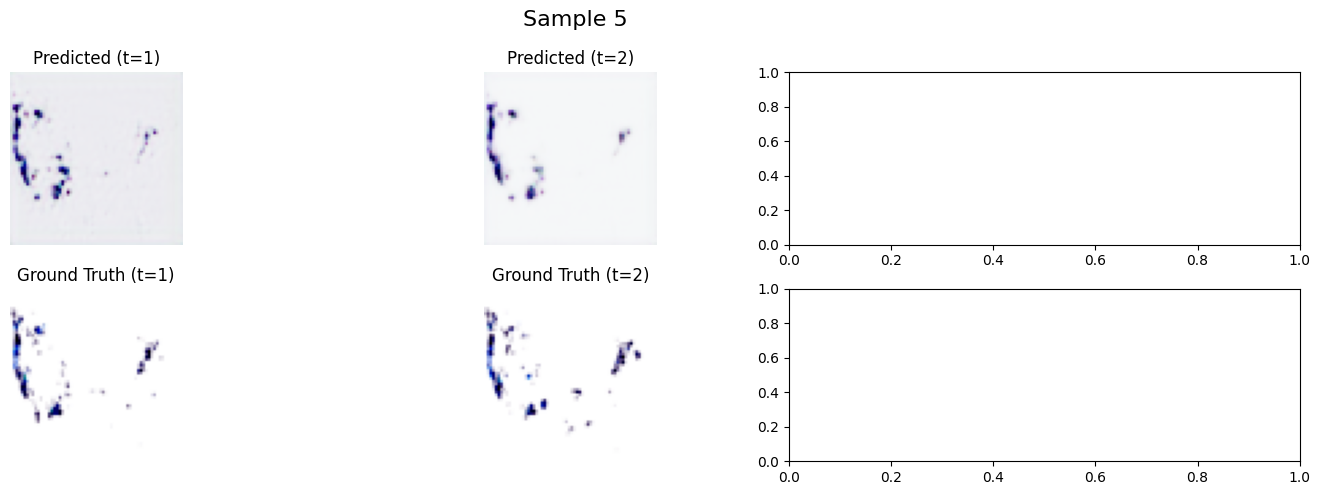

Epoch [9/10], Loss: 0.0023


Epoch [10/10]:   0%|          | 0/37 [00:00<?, ?batch/s]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:   3%|▎         | 1/37 [00:03<02:06,  3.51s/batch, loss=0.0171]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:   5%|▌         | 2/37 [00:04<01:06,  1.90s/batch, loss=0.0198]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:   8%|▊         | 3/37 [00:05<00:46,  1.38s/batch, loss=0.021] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  11%|█         | 4/37 [00:05<00:37,  1.13s/batch, loss=0.0168]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  14%|█▎        | 5/37 [00:06<00:33,  1.05s/batch, loss=0.0146]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  16%|█▌        | 6/37 [00:07<00:29,  1.05batch/s, loss=0.0144]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  19%|█▉        | 7/37 [00:08<00:26,  1.13batch/s, loss=0.0143]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  22%|██▏       | 8/37 [00:08<00:24,  1.18batch/s, loss=0.0182]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  24%|██▍       | 9/37 [00:09<00:24,  1.15batch/s, loss=0.0172]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  27%|██▋       | 10/37 [00:10<00:22,  1.20batch/s, loss=0.0143]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  30%|██▉       | 11/37 [00:11<00:21,  1.24batch/s, loss=0.0148]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  32%|███▏      | 12/37 [00:12<00:19,  1.26batch/s, loss=0.0144]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  35%|███▌      | 13/37 [00:13<00:20,  1.15batch/s, loss=0.0132]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  38%|███▊      | 14/37 [00:13<00:19,  1.20batch/s, loss=0.0135]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  41%|████      | 15/37 [00:14<00:17,  1.23batch/s, loss=0.0149]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  43%|████▎     | 16/37 [00:15<00:16,  1.26batch/s, loss=0.0156]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  46%|████▌     | 17/37 [00:16<00:17,  1.18batch/s, loss=0.0188]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  49%|████▊     | 18/37 [00:17<00:15,  1.21batch/s, loss=0.0213]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  51%|█████▏    | 19/37 [00:18<00:14,  1.22batch/s, loss=0.0224]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  54%|█████▍    | 20/37 [00:18<00:13,  1.24batch/s, loss=0.0183]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  57%|█████▋    | 21/37 [00:20<00:15,  1.02batch/s, loss=0.0209]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  59%|█████▉    | 22/37 [00:20<00:13,  1.09batch/s, loss=0.0196]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  62%|██████▏   | 23/37 [00:21<00:12,  1.15batch/s, loss=0.019] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  65%|██████▍   | 24/37 [00:22<00:10,  1.20batch/s, loss=0.021]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  68%|██████▊   | 25/37 [00:23<00:10,  1.13batch/s, loss=0.0186]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  70%|███████   | 26/37 [00:24<00:09,  1.17batch/s, loss=0.0174]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  73%|███████▎  | 27/37 [00:25<00:08,  1.20batch/s, loss=0.0143]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  76%|███████▌  | 28/37 [00:25<00:07,  1.23batch/s, loss=0.0148]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  78%|███████▊  | 29/37 [00:26<00:06,  1.16batch/s, loss=0.0184]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  81%|████████  | 30/37 [00:27<00:05,  1.20batch/s, loss=0.024] 

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  84%|████████▍ | 31/37 [00:28<00:04,  1.23batch/s, loss=0.0248]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  86%|████████▋ | 32/37 [00:29<00:03,  1.25batch/s, loss=0.0233]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  89%|████████▉ | 33/37 [00:30<00:03,  1.15batch/s, loss=0.0206]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  92%|█████████▏| 34/37 [00:30<00:02,  1.20batch/s, loss=0.0175]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  95%|█████████▍| 35/37 [00:31<00:01,  1.24batch/s, loss=0.0193]

torch.Size([16, 4, 3, 64, 64])
Original pred shape: torch.Size([16, 3, 3, 64, 64])
Original target shape: torch.Size([16, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]:  97%|█████████▋| 36/37 [00:32<00:00,  1.27batch/s, loss=0.0233]

torch.Size([12, 4, 3, 64, 64])
Original pred shape: torch.Size([12, 3, 3, 64, 64])
Original target shape: torch.Size([12, 3, 3, 64, 64])
Modified pred_s shape: torch.Size([3, 64, 64])
Modified target_s shape: torch.Size([3, 64, 64])


Epoch [10/10]: 100%|██████████| 37/37 [00:33<00:00,  1.11batch/s, loss=0.0214]


(12, 3, 3, 64, 64)
(12, 3, 3, 64, 64)
(3, 3, 64, 64)


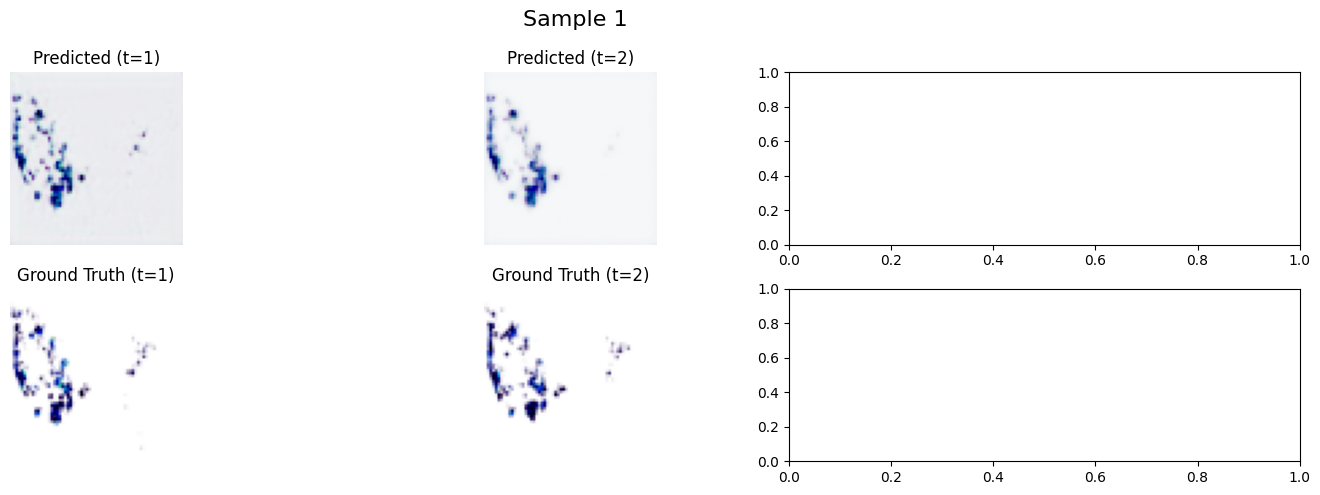

(3, 3, 64, 64)


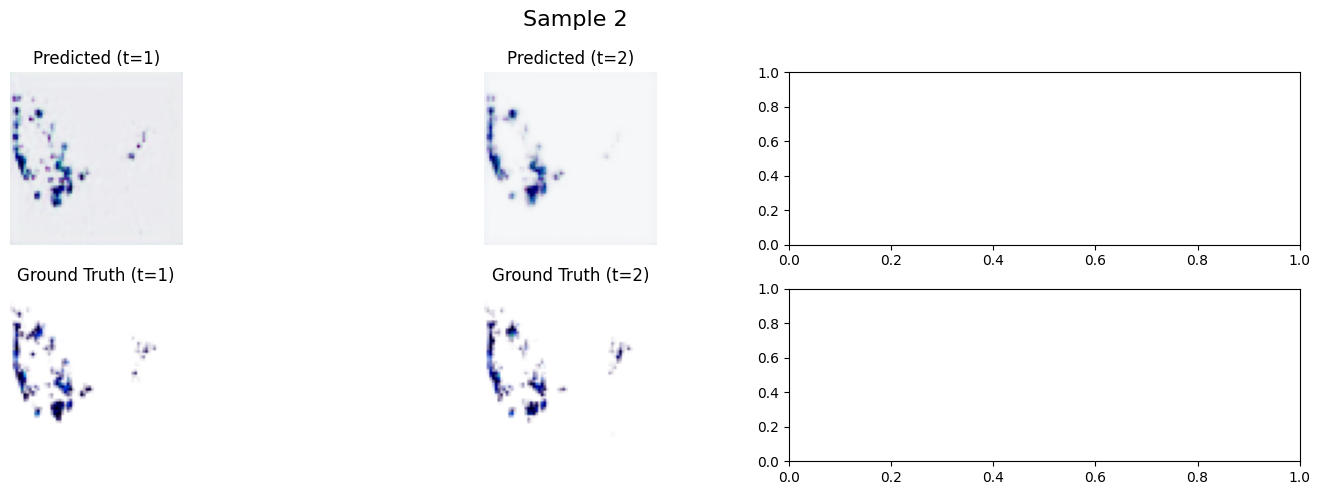

(3, 3, 64, 64)


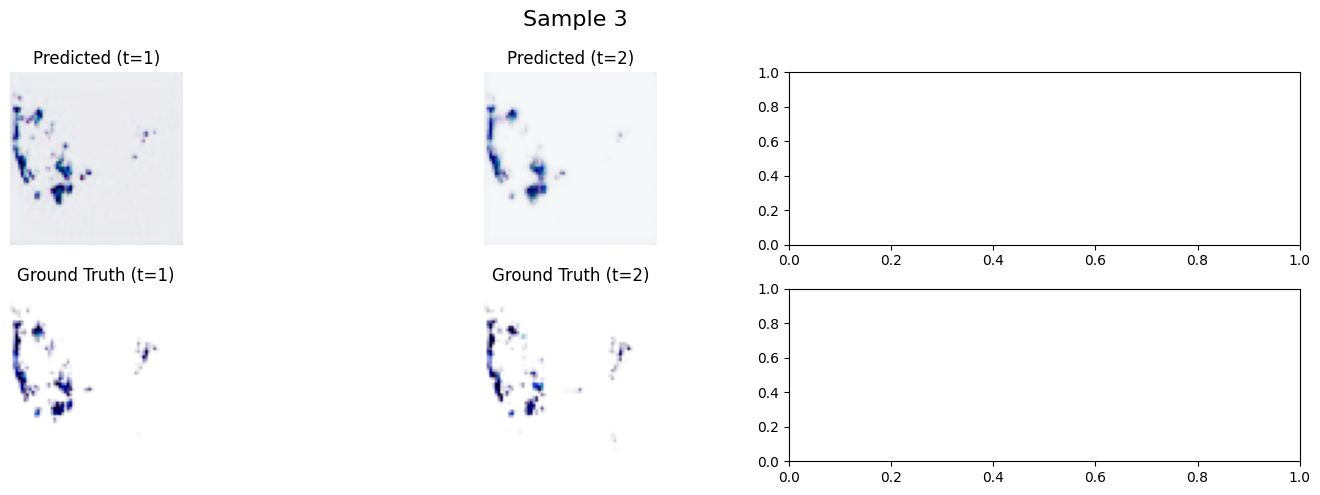

(3, 3, 64, 64)


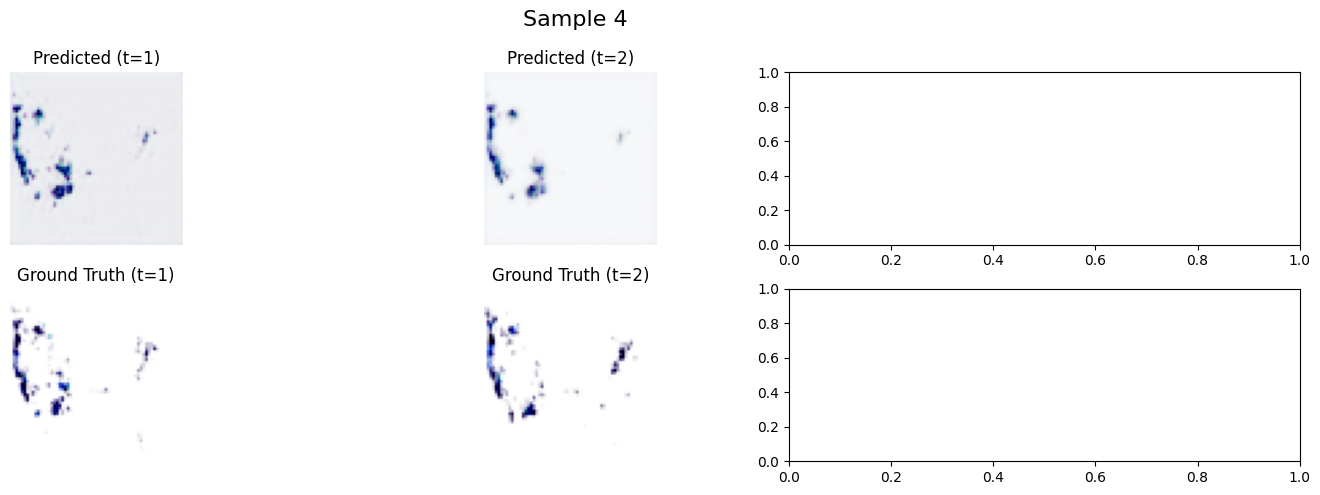

(3, 3, 64, 64)


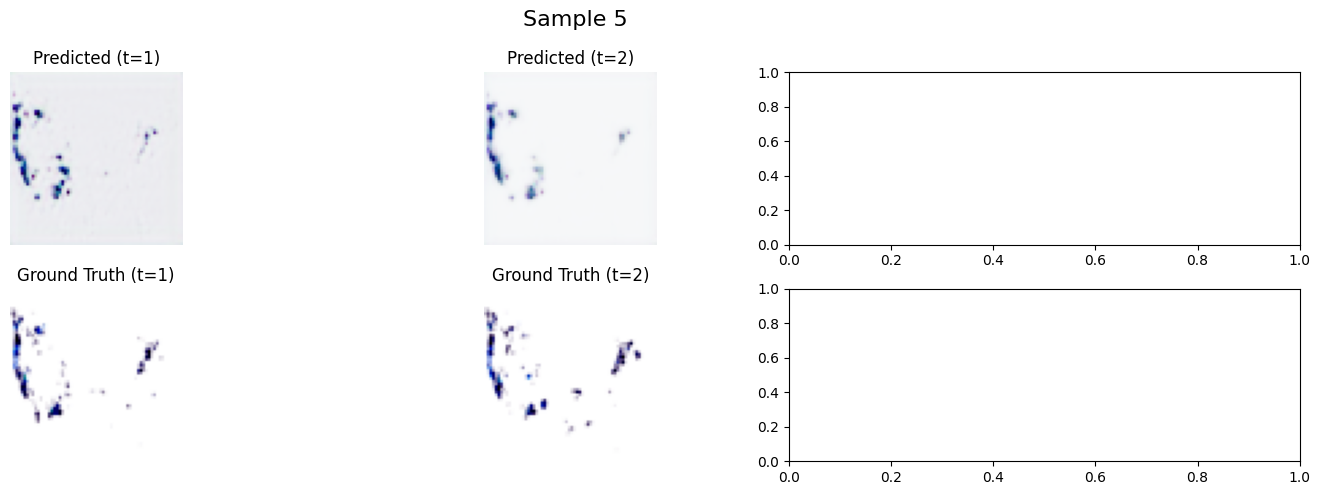

Epoch [10/10], Loss: 0.0023
Training complete.


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import vgg16
from torchvision.transforms.functional import to_pil_image

def visualize_predictions_in_notebook(predictions, ground_truth):
    """
    Visualize predictions and ground truth in a Jupyter notebook.

    Args:
        predictions: The predicted frames from the model.
        ground_truth: The ground truth frames.

    Returns:
        None
    """
    predictions = predictions.cpu().detach().numpy()
    ground_truth = ground_truth.cpu().detach().numpy()
    print(predictions.shape)
    print(ground_truth.shape)
    # Visualize up to 5 samples from the batch
    for i in range(min(predictions.shape[0], 5)):
        pred_frames = predictions[i]  # Shape: [T, C, H, W]
        gt_frames = ground_truth[i]  # Shape: [T, C, H, W]
        print(pred_frames.shape)
        num_frames = pred_frames.shape[0]

        fig, axes = plt.subplots(2, num_frames, figsize=(15, 5))
        fig.suptitle(f"Sample {i+1}", fontsize=16)

        for t in range(num_frames-1):
            # Predicted frame
            axes[0, t].imshow(np.transpose(pred_frames[t], (1, 2, 0)))  # Assuming channels-first
            axes[0, t].set_title(f"Predicted (t={t+1})")
            axes[0, t].axis("off")

            # Ground truth frame
            axes[1, t].imshow(np.transpose(gt_frames[t], (1, 2, 0)))  # Assuming channels-first
            axes[1, t].set_title(f"Ground Truth (t={t+1})")
            axes[1, t].axis("off")

        plt.tight_layout()
        plt.show()
        
# ---- VGG-based Perceptual Loss ---- #
class VGGPerceptualLoss(nn.Module):
    def __init__(self, device):
        super(VGGPerceptualLoss, self).__init__()
        vgg = vgg16(pretrained=True).features[:16].eval().to(device)
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.device = device

    def forward(self, pred, target):
        # Rescale from [-1, 1] to [0, 1]
        pred = (pred + 1) / 2  # Rescale [-1, 1] to [0, 1]
        target = (target + 1) / 2  # Rescale [-1, 1] to [0, 1]
        
        # Ensure inputs are clamped within [0, 1] to prevent out-of-bound values
        pred = torch.clamp(pred, 0, 1)
        target = torch.clamp(target, 0, 1)
        # Check the size of the second dimension (Time dimension)
        
        # Now T >= 3 for both pred and target
        pred_s = pred[0,0]  # Remove the second frame
        target_s = target[0, 0]  # Remove the second frame
        
        # Debug shapes to ensure correctness
        print(f"Original pred shape: {pred.shape}")
        print(f"Original target shape: {target.shape}")
        print(f"Modified pred_s shape: {pred_s.shape}")
        print(f"Modified target_s shape: {target_s.shape}")
        return F.mse_loss(self.vgg(pred_s), self.vgg(target_s))




def train_predrnn(model, dataloader, configs, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=configs.lr)
    perceptual_loss = VGGPerceptualLoss(device=device)
    
    for epoch in range(configs.epochs):
        model.train()
        total_loss = 0.0
        idx=0
        # Initialize the progress bar for the current epoch
        with tqdm(total=len(dataloader), desc=f"Epoch [{epoch+1}/{configs.epochs}]", unit="batch") as pbar:
            for batch in dataloader:
                batch = batch.to(device)  # (B, T, H, W, C)
                print(batch.shape)
                print(dataloader)
                # Create mask_true tensor with scheduled sampling (all 1s = always use GT)
                mask_true = batch[:,1:] # (B, T-1, H, W, C)

                optimizer.zero_grad()
                output, loss = model(batch,mask_true)
                loss_perc = perceptual_loss(batch[:,1:], output)
                loss = loss.mean()
                # Combine losses: You can tweak weights if needed
                total_loss = loss + 0.1 * loss_perc
                
                total_loss.backward()
                optimizer.step()
    
                total_loss += loss.item()
    
                # Update the progress bar for each batch
                pbar.set_postfix({"loss": loss.item()})
                
                    
                  # Visualize only the first batch
                pbar.update(1)
                
        visualize_predictions_in_notebook(output, batch[:, 1:])
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{configs.epochs}], Loss: {avg_loss:.4f}")

    print("Training complete.")
    return model
# -------------------- Run Training --------------------

if __name__ == "__main__":
    img_dir = '/kaggle/input/dataimages/data'  # <--- change this
    batch_size = 16
    sequence_length = 4
    t_in = 5
    t_out = 5
    num_epochs = 5
    class Config:
        img_width = 64
        patch_size = 1
        img_channel = 3
        filter_size = 5
        stride = 1
        layer_norm = True
        device = "cuda" if torch.cuda.is_available() else "cpu"
        total_length = 4  # input + predicted frames
        input_length = 3
        reverse_scheduled_sampling = 0
        decouple_beta = 0.1
        visual = 0
        visual_path = "./visual"
        lr = 1e-4
        epochs = 10

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataloader = get_data_loaders(img_dir, batch_size=batch_size, sequence_length=sequence_length)
    configs = Config()
    model = PredRNN(num_layers=4, num_hidden=[64, 64, 64, 64], configs=configs)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)



    trained_model = train_predrnn(model, dataloader, configs, configs.device)

In [13]:
torch.save(trained_model.state_dict(), "predrnn2.pth")

16
tensor(-0.7098, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.5747, device='cuda:0') tensor(0.9811, device='cuda:0')
(16, 3, 3, 64, 64)
(16, 3, 3, 64, 64)
(3, 3, 64, 64)


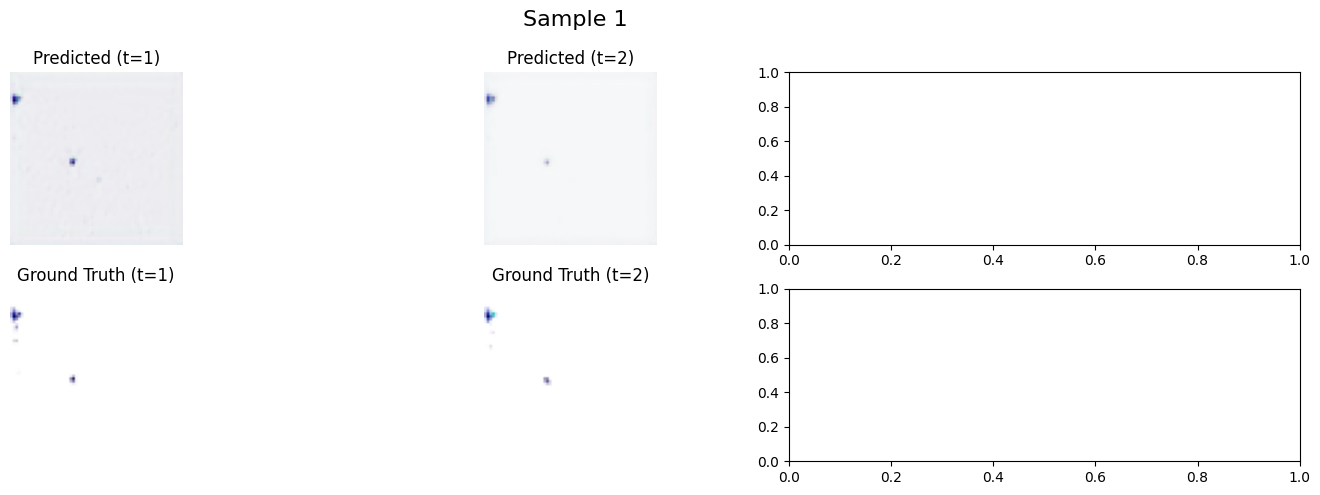

(3, 3, 64, 64)


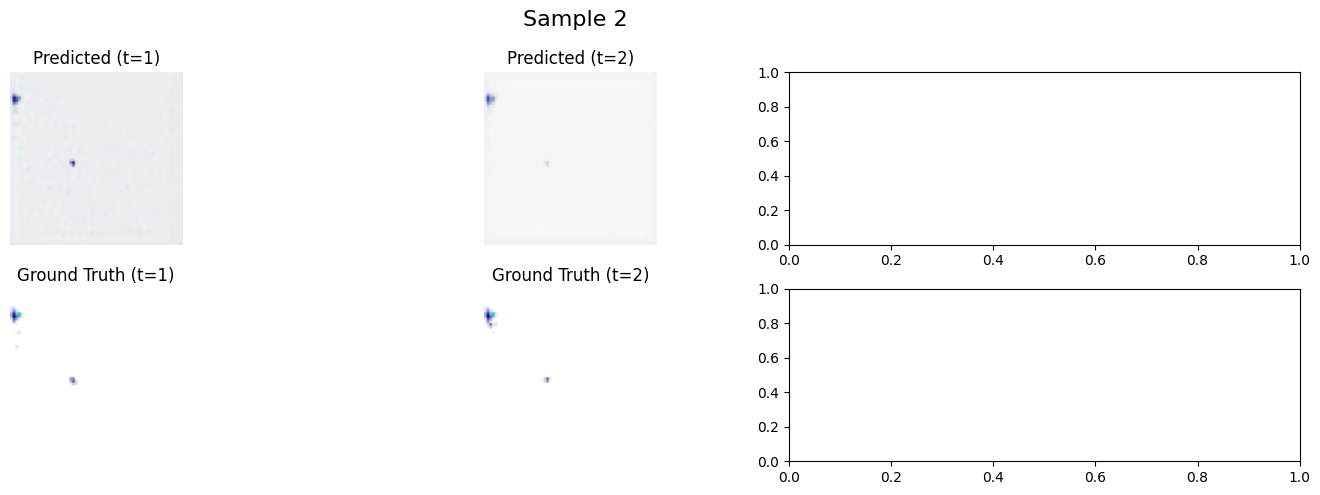

(3, 3, 64, 64)


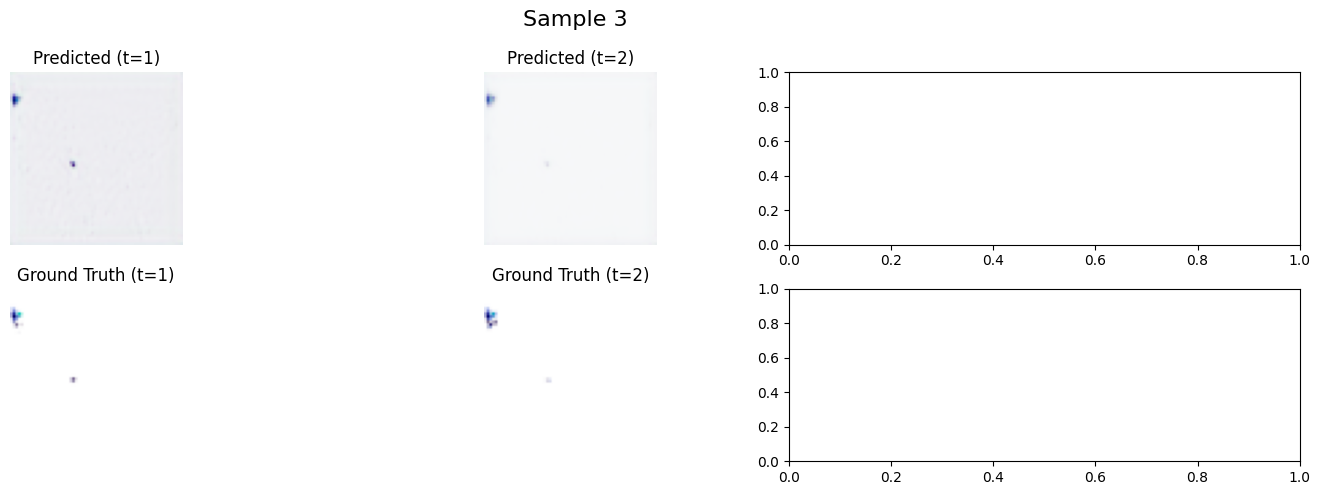

(3, 3, 64, 64)


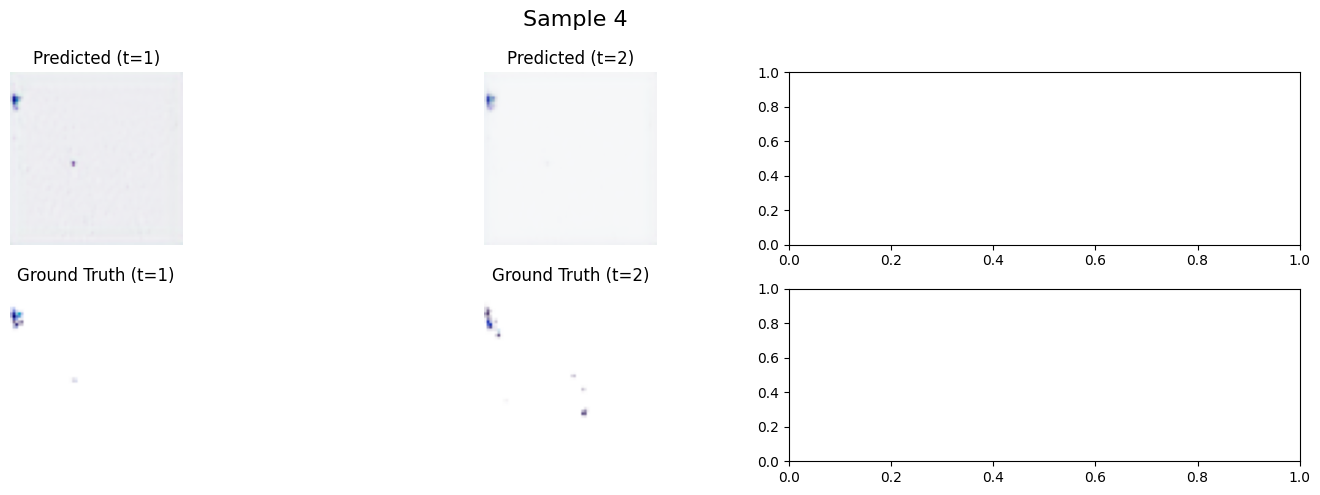

(3, 3, 64, 64)


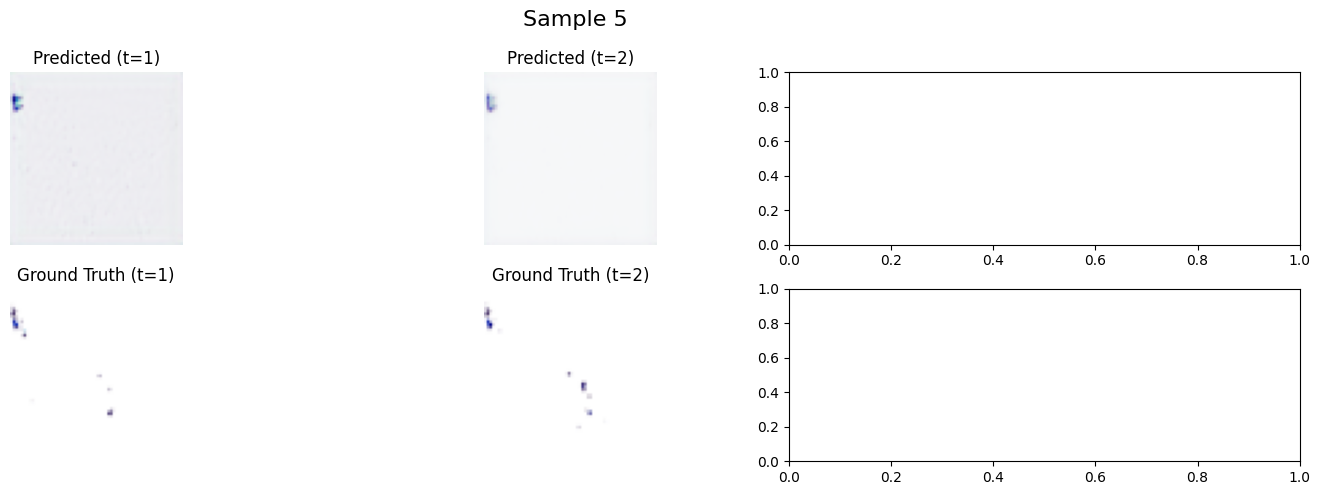

tensor(-0.7882, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.6650, device='cuda:0') tensor(0.9807, device='cuda:0')
(16, 3, 3, 64, 64)
(16, 3, 3, 64, 64)
(3, 3, 64, 64)


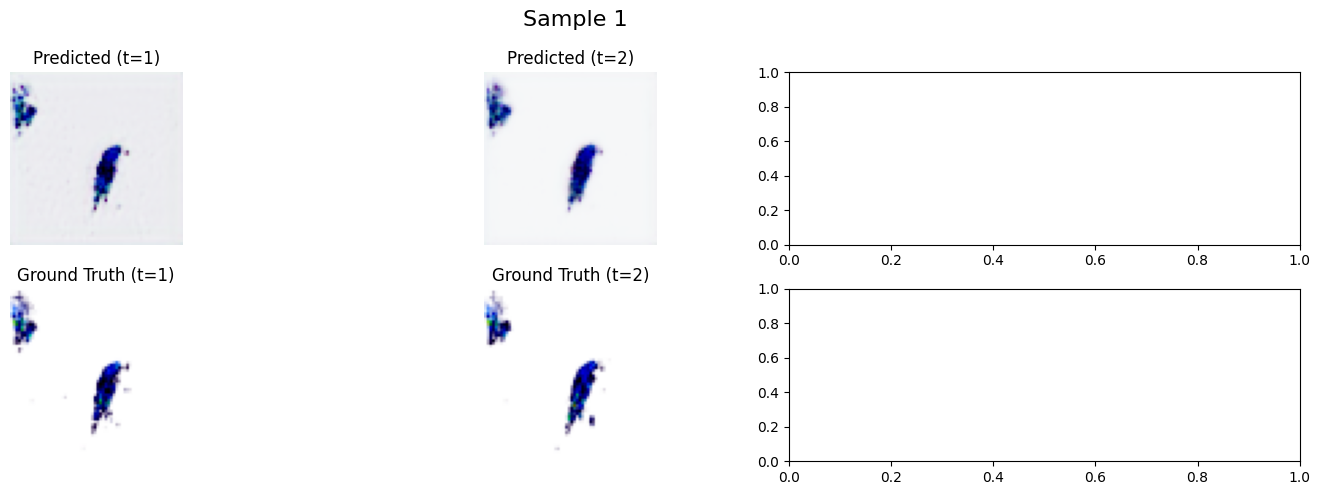

(3, 3, 64, 64)


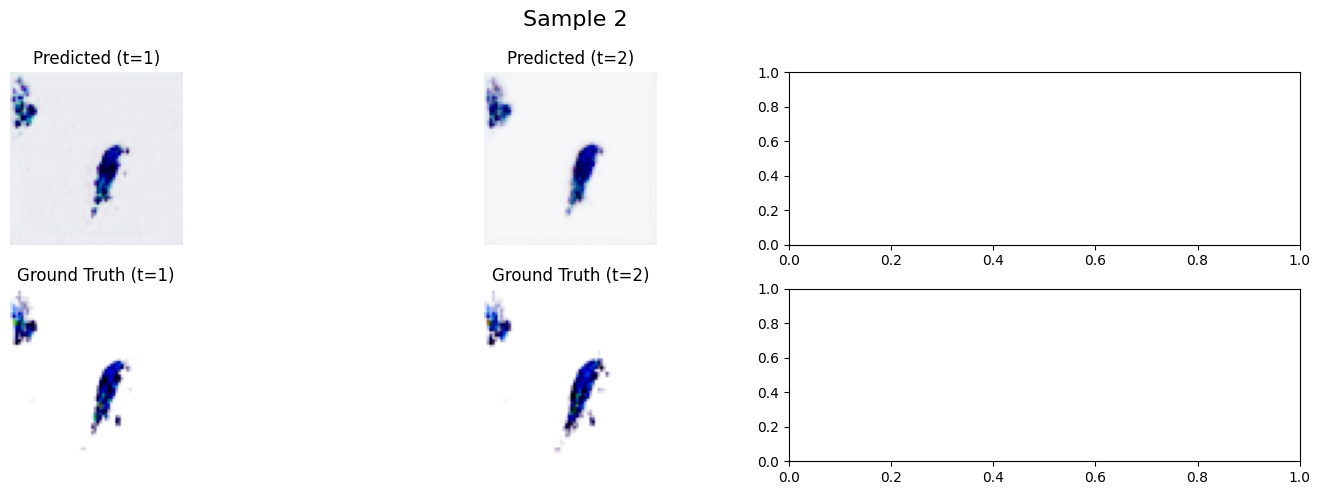

(3, 3, 64, 64)


(3, 3, 64, 64)


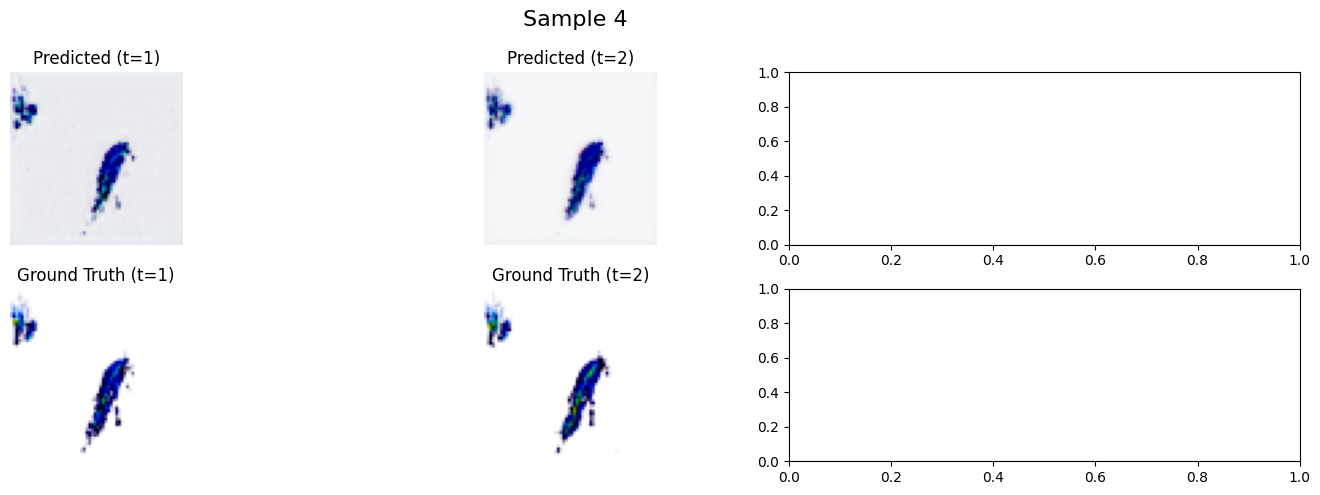

(3, 3, 64, 64)


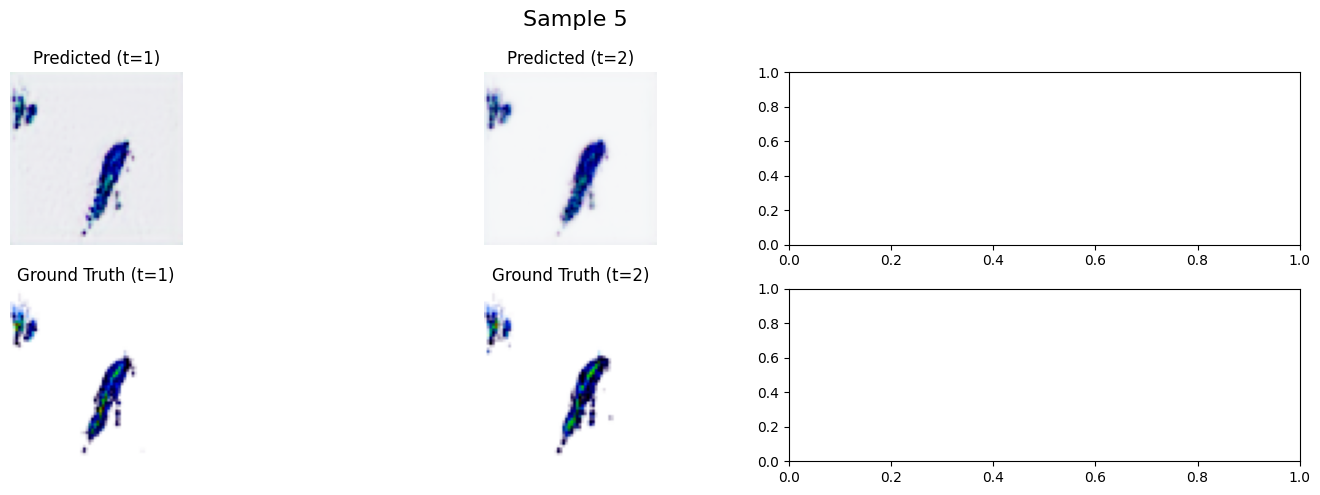

tensor(-0.9529, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.6602, device='cuda:0') tensor(0.9807, device='cuda:0')
(16, 3, 3, 64, 64)
(16, 3, 3, 64, 64)
(3, 3, 64, 64)


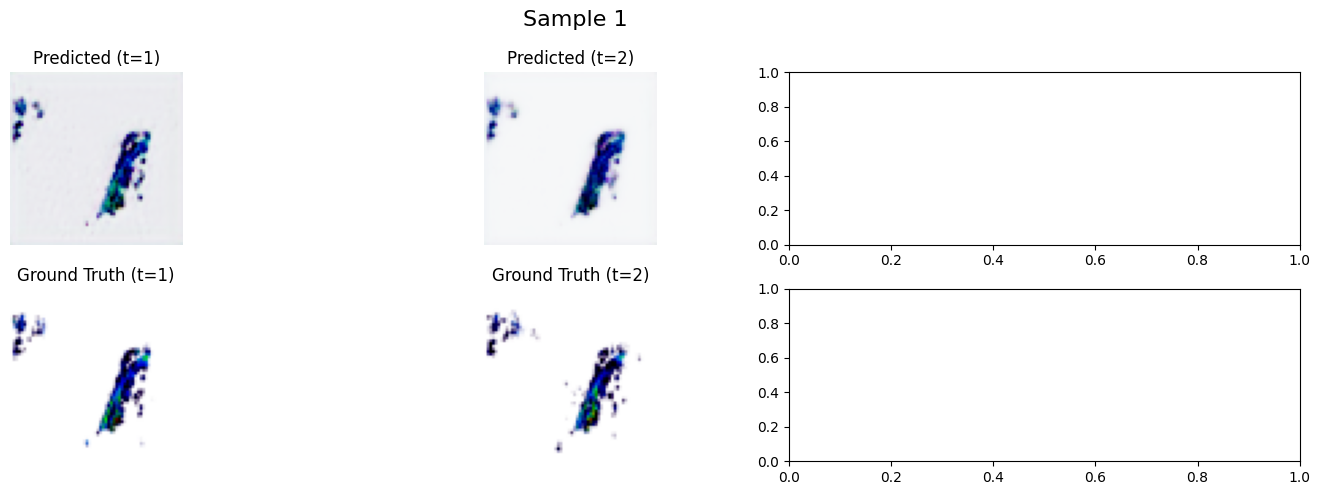

(3, 3, 64, 64)


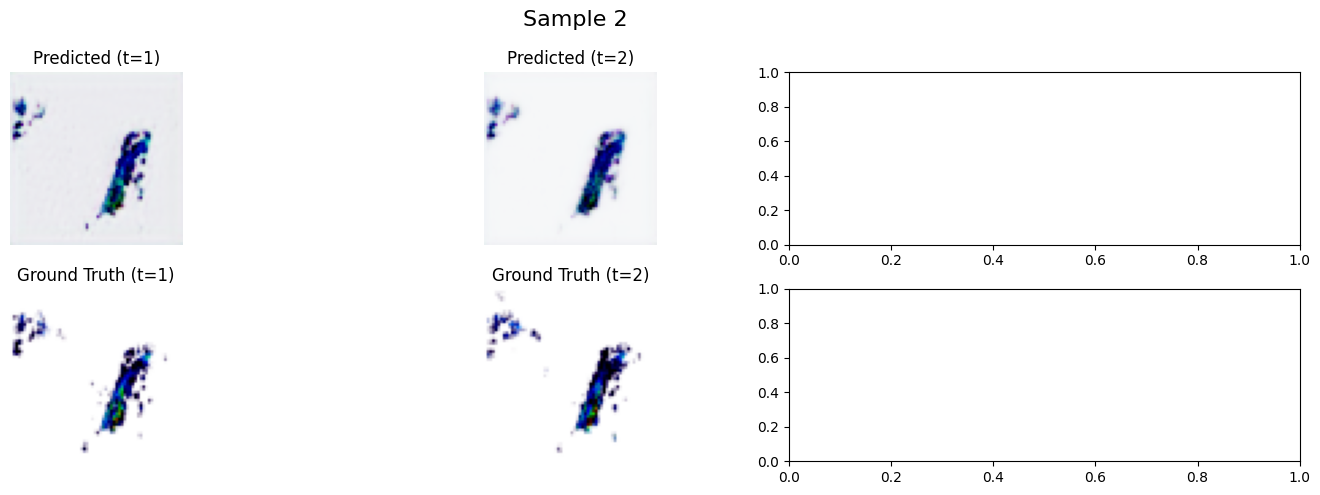

(3, 3, 64, 64)


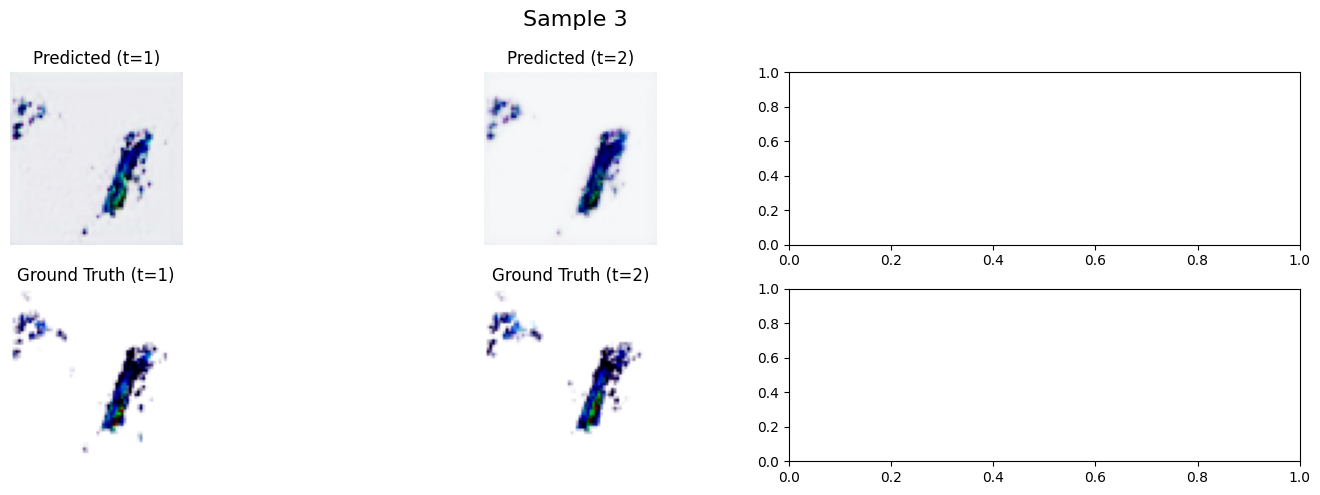

(3, 3, 64, 64)


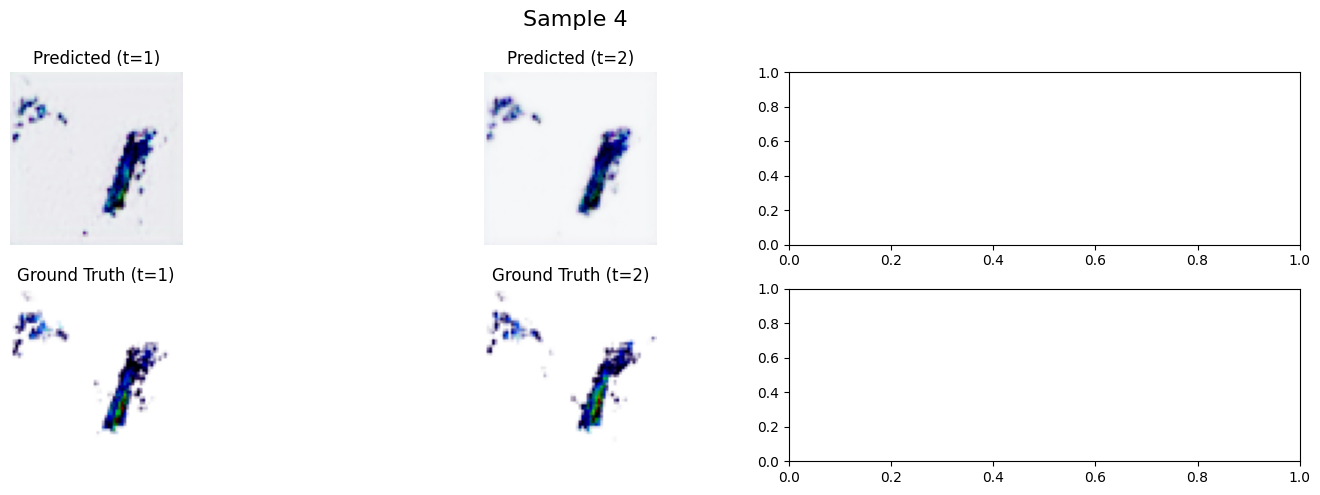

(3, 3, 64, 64)


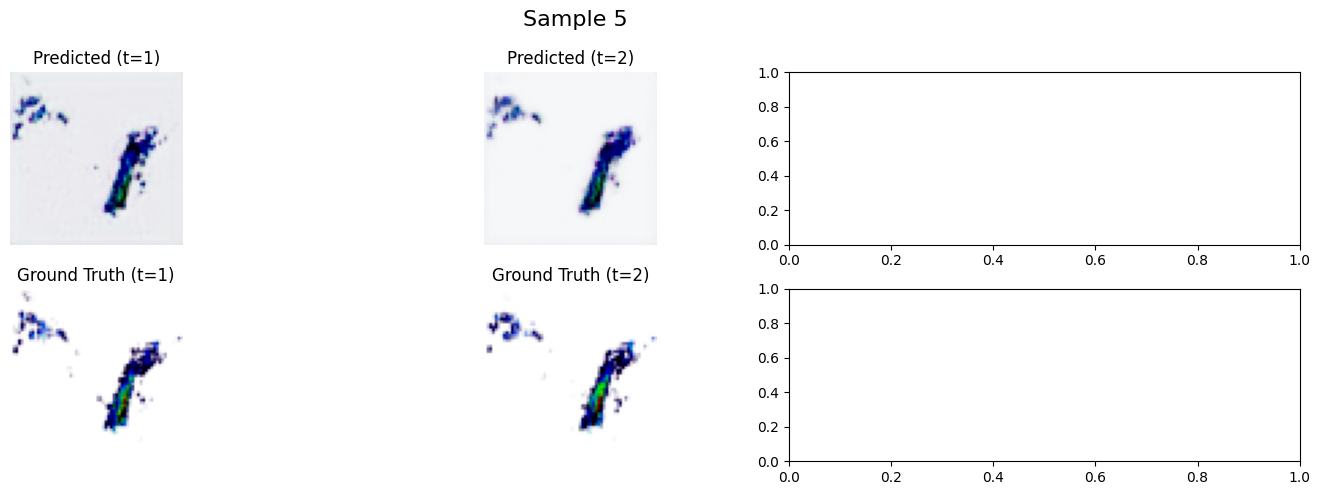

tensor(-0.9216, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.6523, device='cuda:0') tensor(0.9810, device='cuda:0')
(16, 3, 3, 64, 64)
(16, 3, 3, 64, 64)
(3, 3, 64, 64)


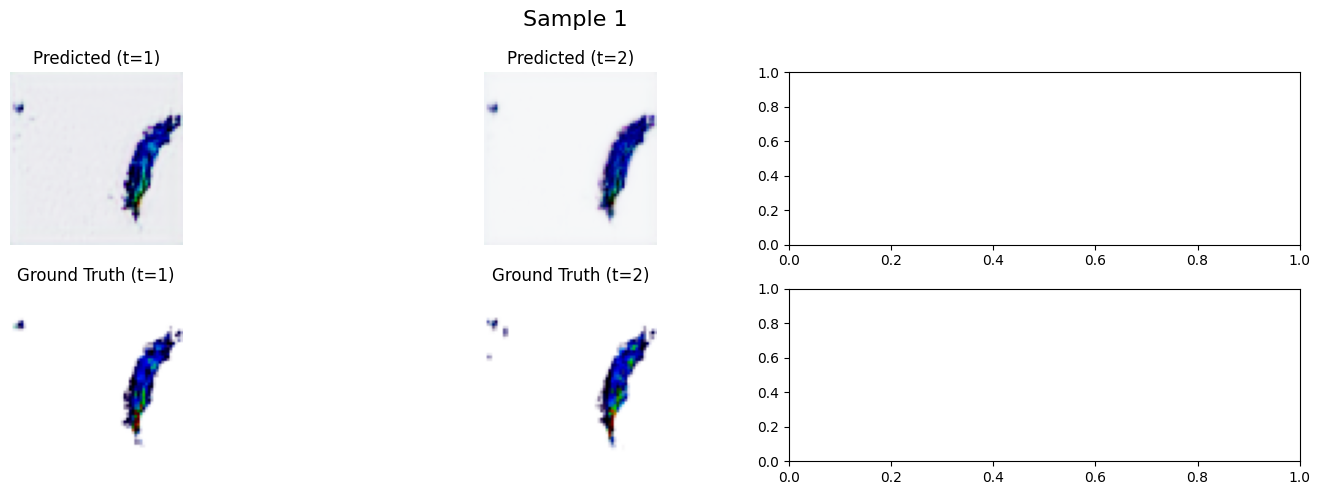

(3, 3, 64, 64)


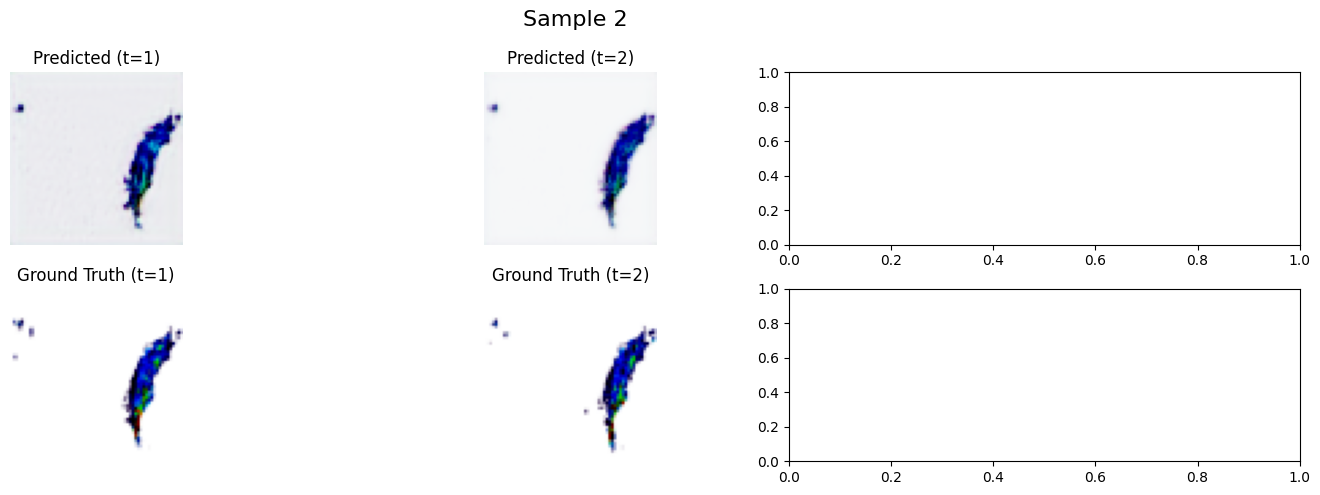

(3, 3, 64, 64)


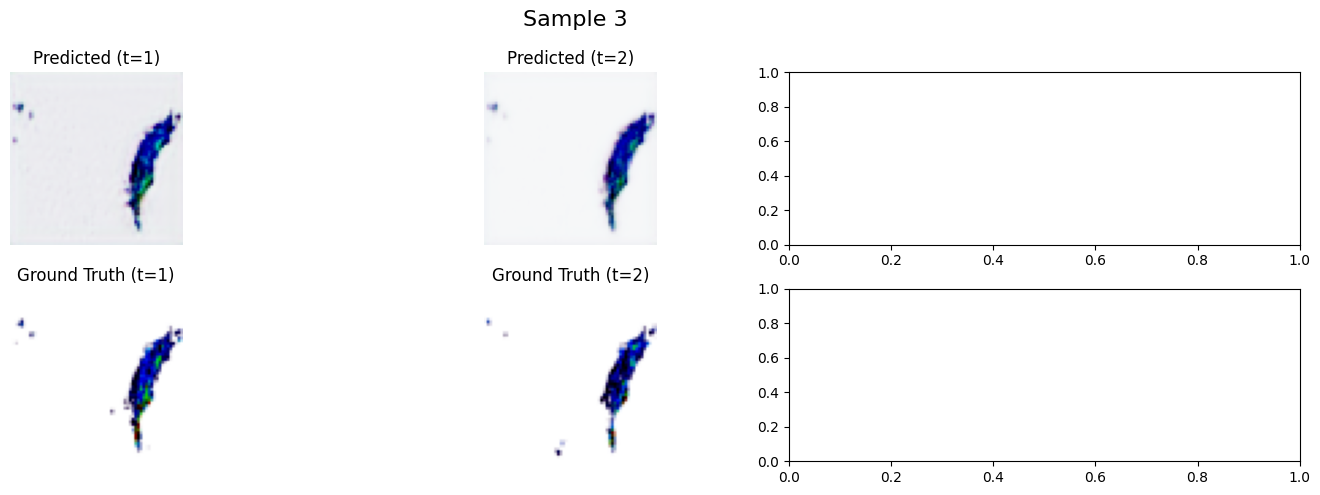

(3, 3, 64, 64)


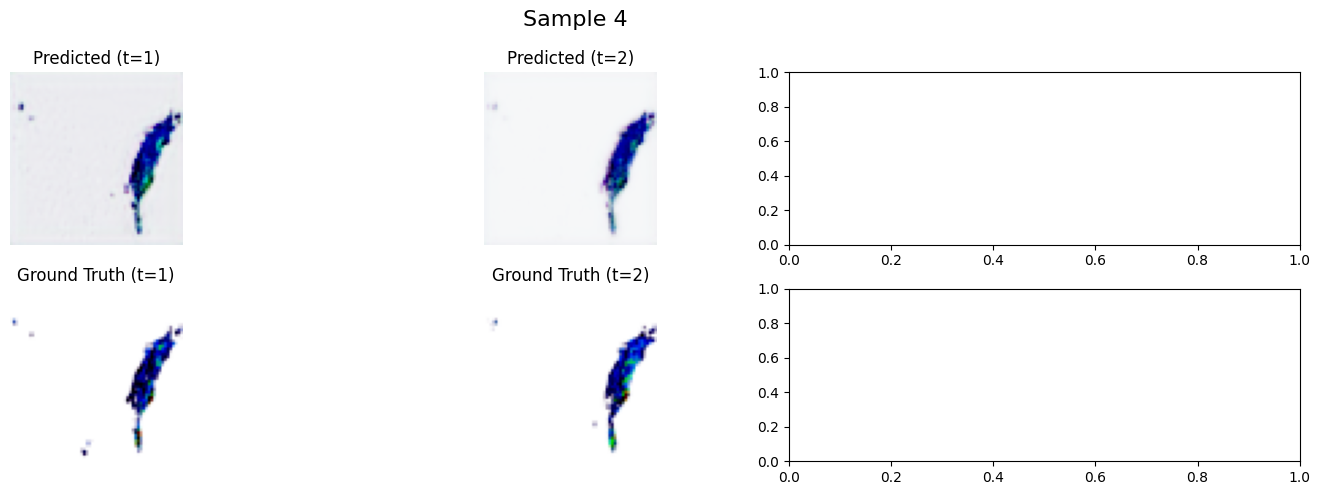

(3, 3, 64, 64)


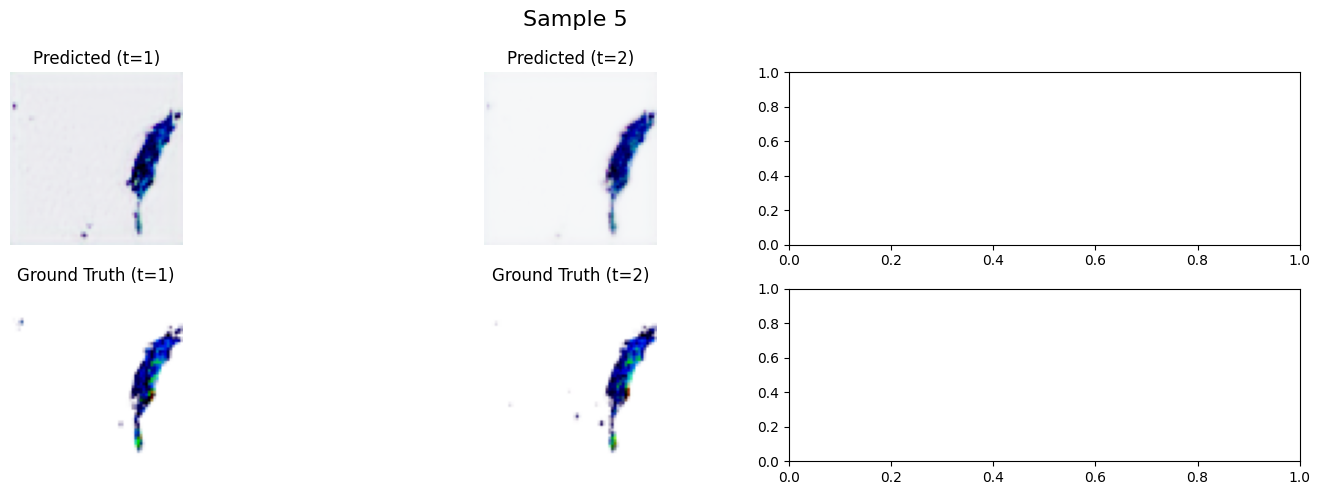

tensor(-0.6549, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.5384, device='cuda:0') tensor(0.9811, device='cuda:0')
(16, 3, 3, 64, 64)
(16, 3, 3, 64, 64)
(3, 3, 64, 64)


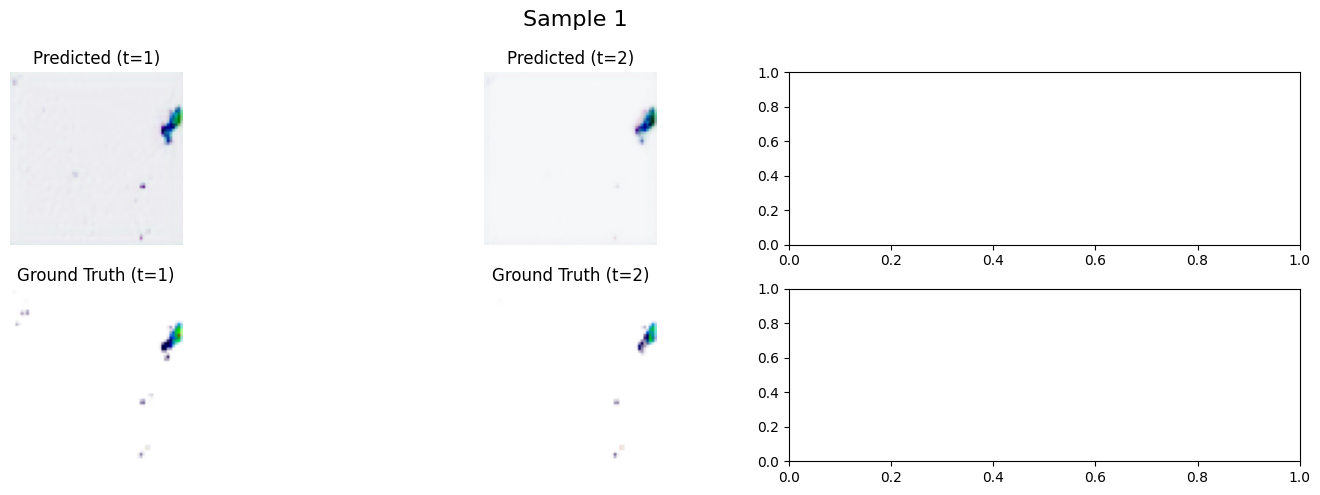

(3, 3, 64, 64)


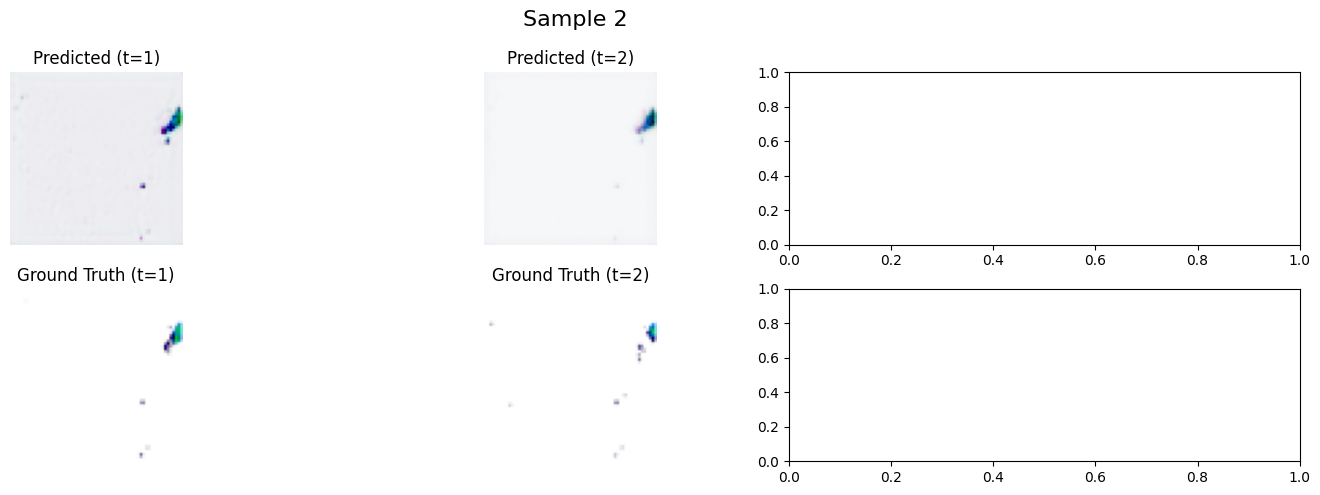

(3, 3, 64, 64)


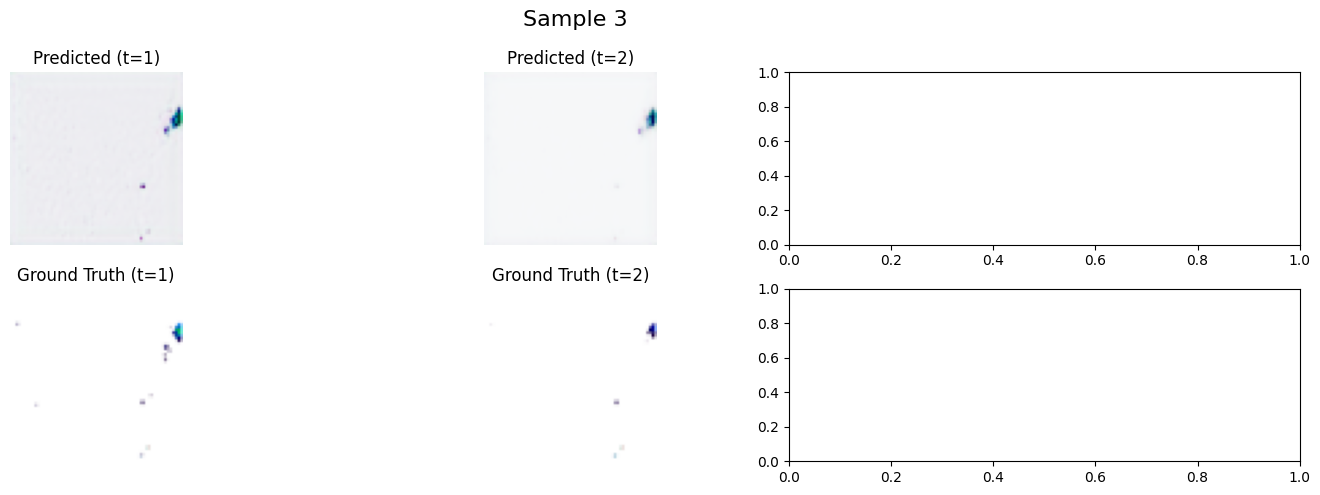

(3, 3, 64, 64)


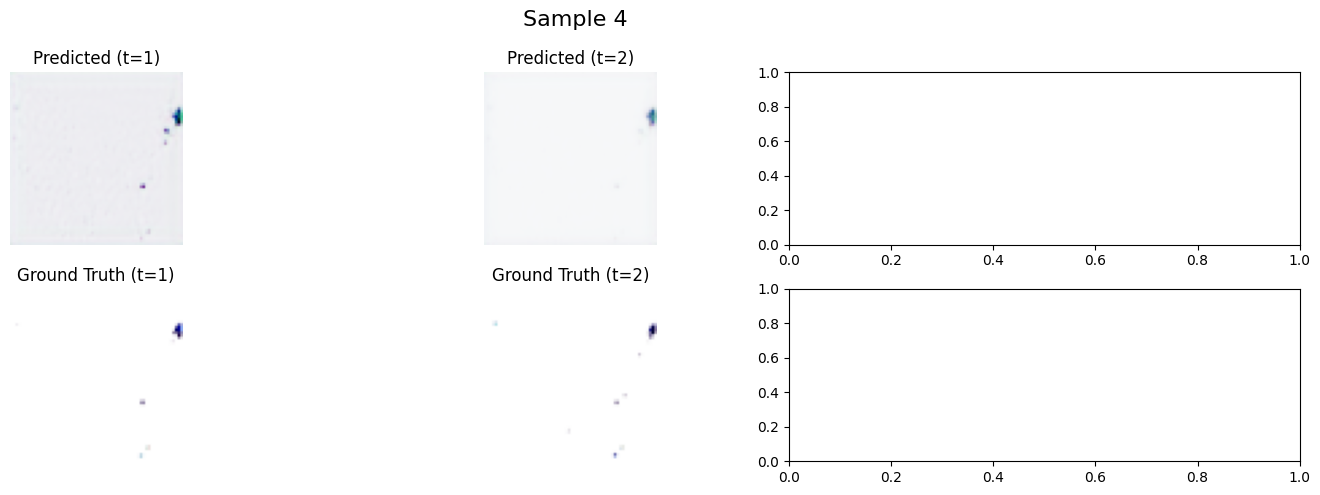

(3, 3, 64, 64)


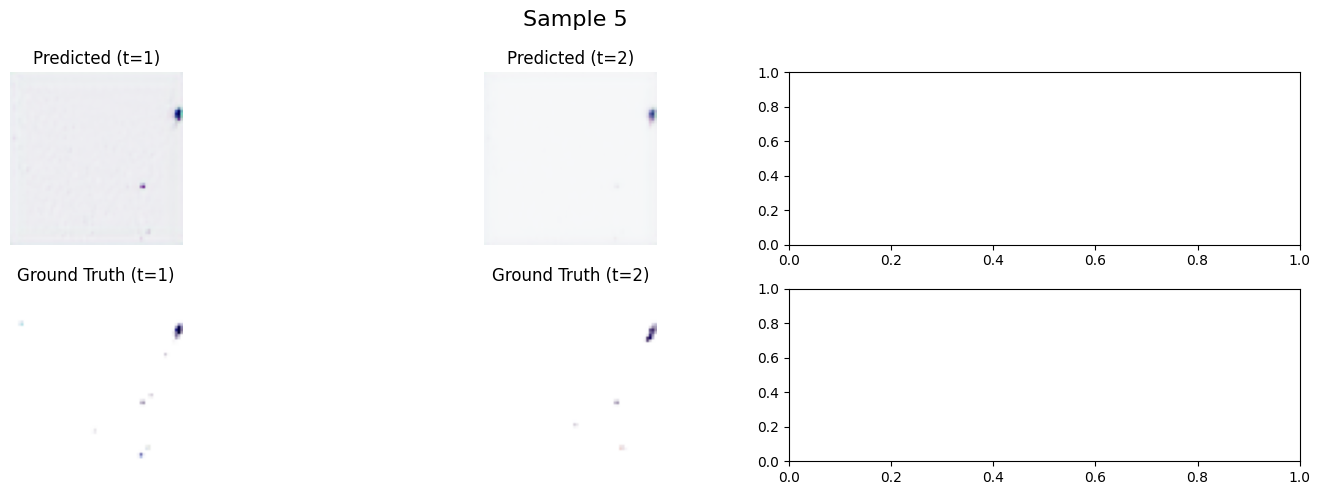

tensor(-0.4980, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.3308, device='cuda:0') tensor(0.9811, device='cuda:0')
tensor(-0.4745, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.3917, device='cuda:0') tensor(0.9811, device='cuda:0')
tensor(-0.7569, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.5551, device='cuda:0') tensor(0.9812, device='cuda:0')
tensor(-0.7647, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.5173, device='cuda:0') tensor(0.9813, device='cuda:0')
tensor(-0.7098, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.5080, device='cuda:0') tensor(0.9812, device='cuda:0')
tensor(-0.6392, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.5960, device='cuda:0') tensor(0.9812, device='cuda:0')
tensor(-0.6235, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.5719, device='cuda:0') tensor(0.9810, device='cuda:0')
tensor(-0.4118, device='cuda:0') tensor(1., device='cuda:0')
tensor(-0.3938, device='cuda:0') tensor(0.9811, device='c

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def test_predrnn_notebook(model, test_dataloader, device):
    """
    Function to test the PredRNN model and visualize results in a notebook.

    Args:
        model: The trained PredRNN model.
        test_dataloader: DataLoader for the test dataset.
        device: The device (CPU or GPU) to run the testing.

    Returns:
        None
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    criterion = torch.nn.MSELoss()

    with torch.no_grad():  # No gradients required during testing
        for batch_idx, frames in enumerate(test_dataloader):
            # Move data to the appropriate device
            frames = frames.to(device)
            mask_true = torch.zeros_like(frames[:, 1:])
            mask_true = mask_true.to(device)
            print(frames.min(), frames.max())

            # Forward pass
            predictions, loss = model(frames,mask_true)
            print(predictions.min(), predictions.max())

            # Compute batch loss
            batch_loss = criterion(predictions, frames[:, 1:])
            total_loss += batch_loss.item()
            
            # Visualize results for the first batch only
            if batch_idx < 5:
                visualize_predictions_in_notebook(predictions, frames[:, 1:])
               # Visualize only the first batch

    # Compute and print average loss
    avg_loss = total_loss / len(test_dataloader)
    print(f"Average Test Loss: {avg_loss}")


def visualize_predictions_in_notebook(predictions, ground_truth):
    """
    Visualize predictions and ground truth in a Jupyter notebook.

    Args:
        predictions: The predicted frames from the model.
        ground_truth: The ground truth frames.

    Returns:
        None
    """
    predictions = predictions.cpu().numpy()
    ground_truth = ground_truth.cpu().numpy()
    print(predictions.shape)
    print(ground_truth.shape)
    # Visualize up to 5 samples from the batch
    for i in range(min(predictions.shape[0], 5)):
        pred_frames = predictions[i]  # Shape: [T, C, H, W]
        gt_frames = ground_truth[i]  # Shape: [T, C, H, W]
        print(pred_frames.shape)
        num_frames = pred_frames.shape[0]

        fig, axes = plt.subplots(2, num_frames, figsize=(15, 5))
        fig.suptitle(f"Sample {i+1}", fontsize=16)

        for t in range(num_frames-1):
            # Predicted frame
            axes[0, t].imshow(np.transpose(pred_frames[t], (1, 2, 0)))  # Assuming channels-first
            axes[0, t].set_title(f"Predicted (t={t+1})")
            axes[0, t].axis("off")

            # Ground truth frame
            axes[1, t].imshow(np.transpose(gt_frames[t], (1, 2, 0)))  # Assuming channels-first
            axes[1, t].set_title(f"Ground Truth (t={t+1})")
            axes[1, t].axis("off")

        plt.tight_layout()
        plt.show()


# Example Usage in a Notebook:
# Assuming `test_dataloader` is your test dataset's DataLoader
# and `model` is your trained PredRNN model.
test_dataloader=get_data_loaders(img_dir, batch_size=batch_size, sequence_length=sequence_length)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_predrnn_notebook(trained_model, test_dataloader, device)